
Processing test_image_1.tif


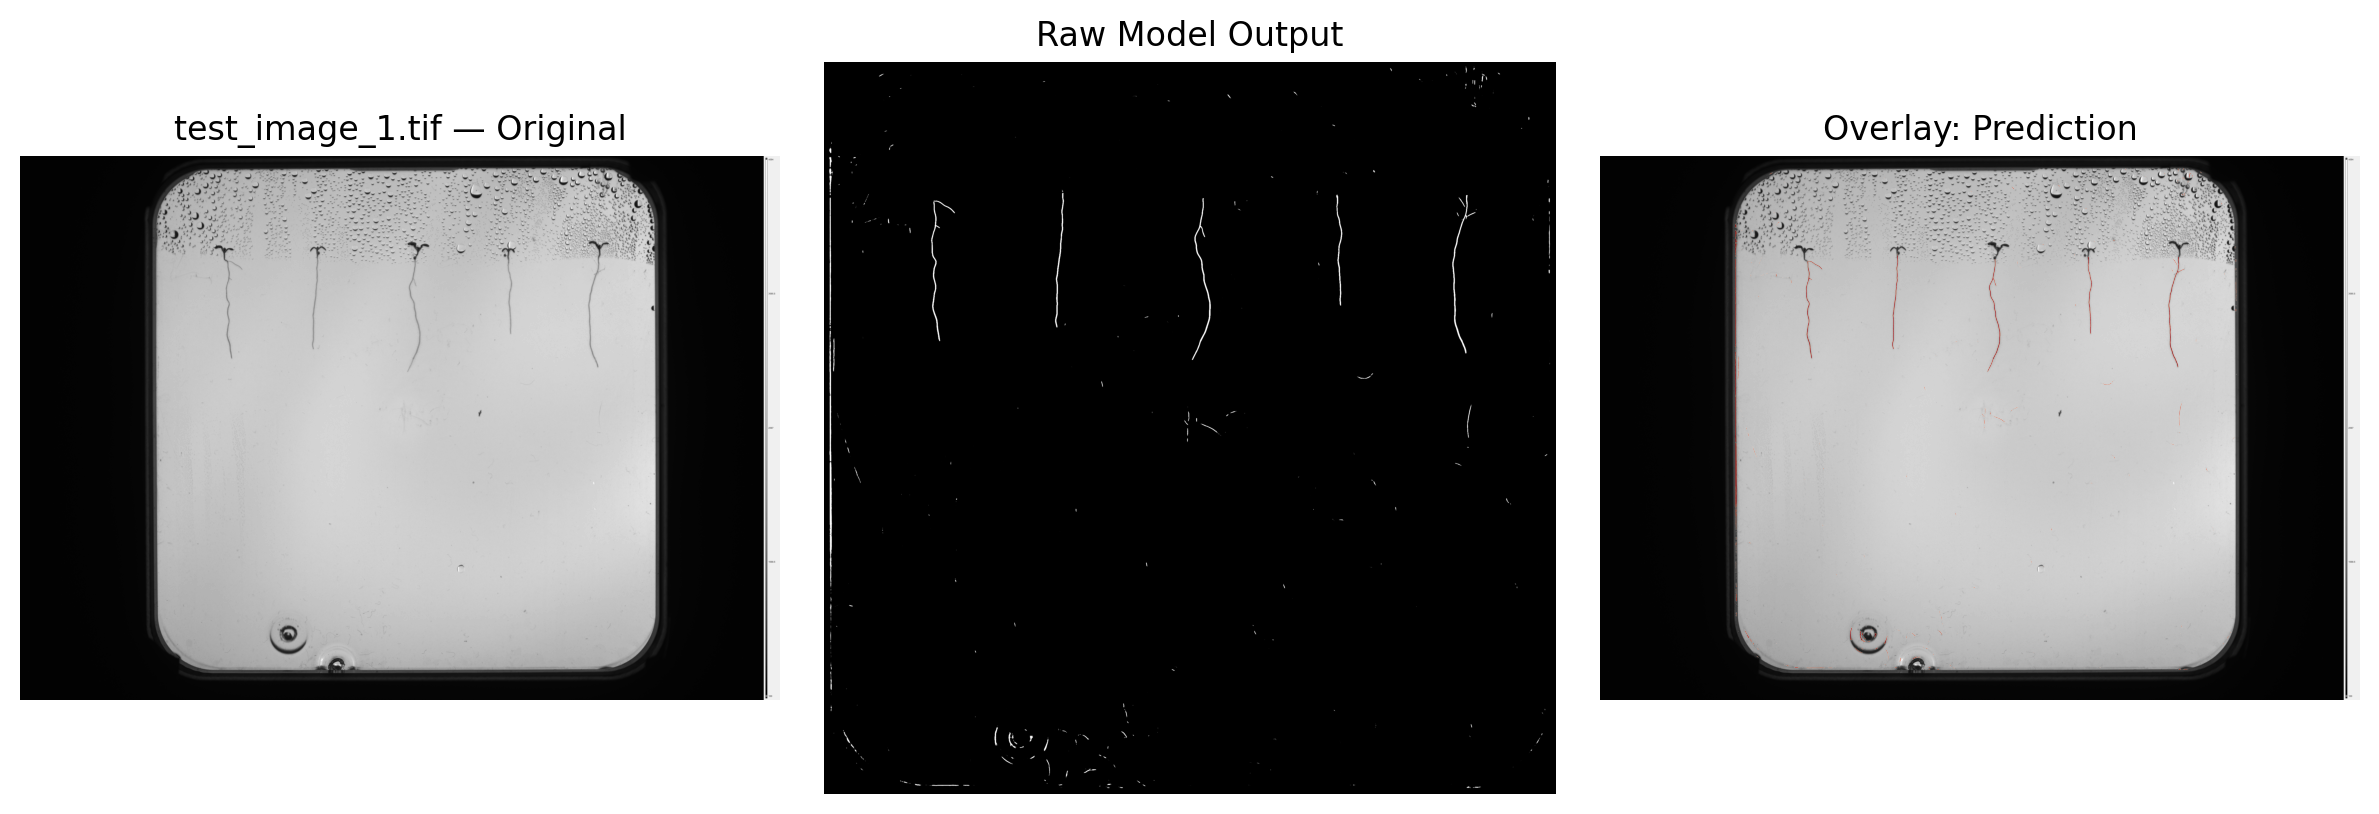


Processing test_image_10.tif


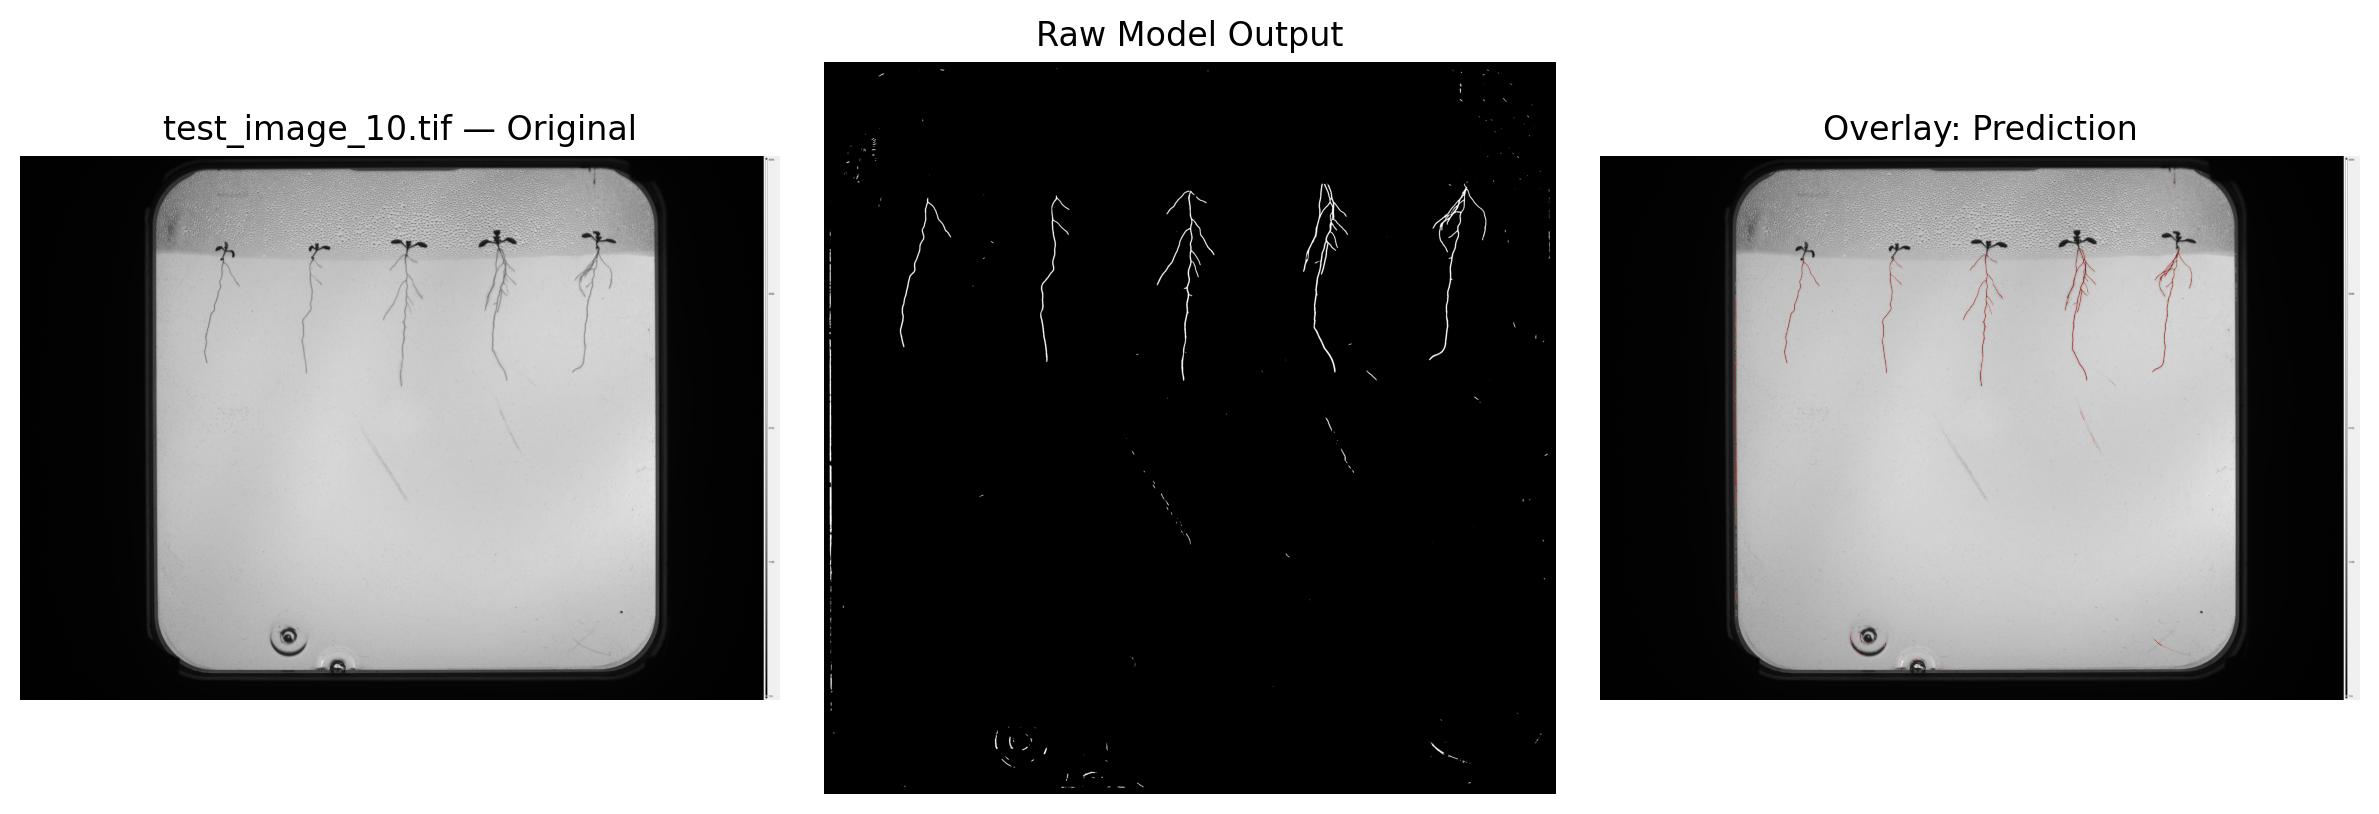


Processing test_image_11.tif


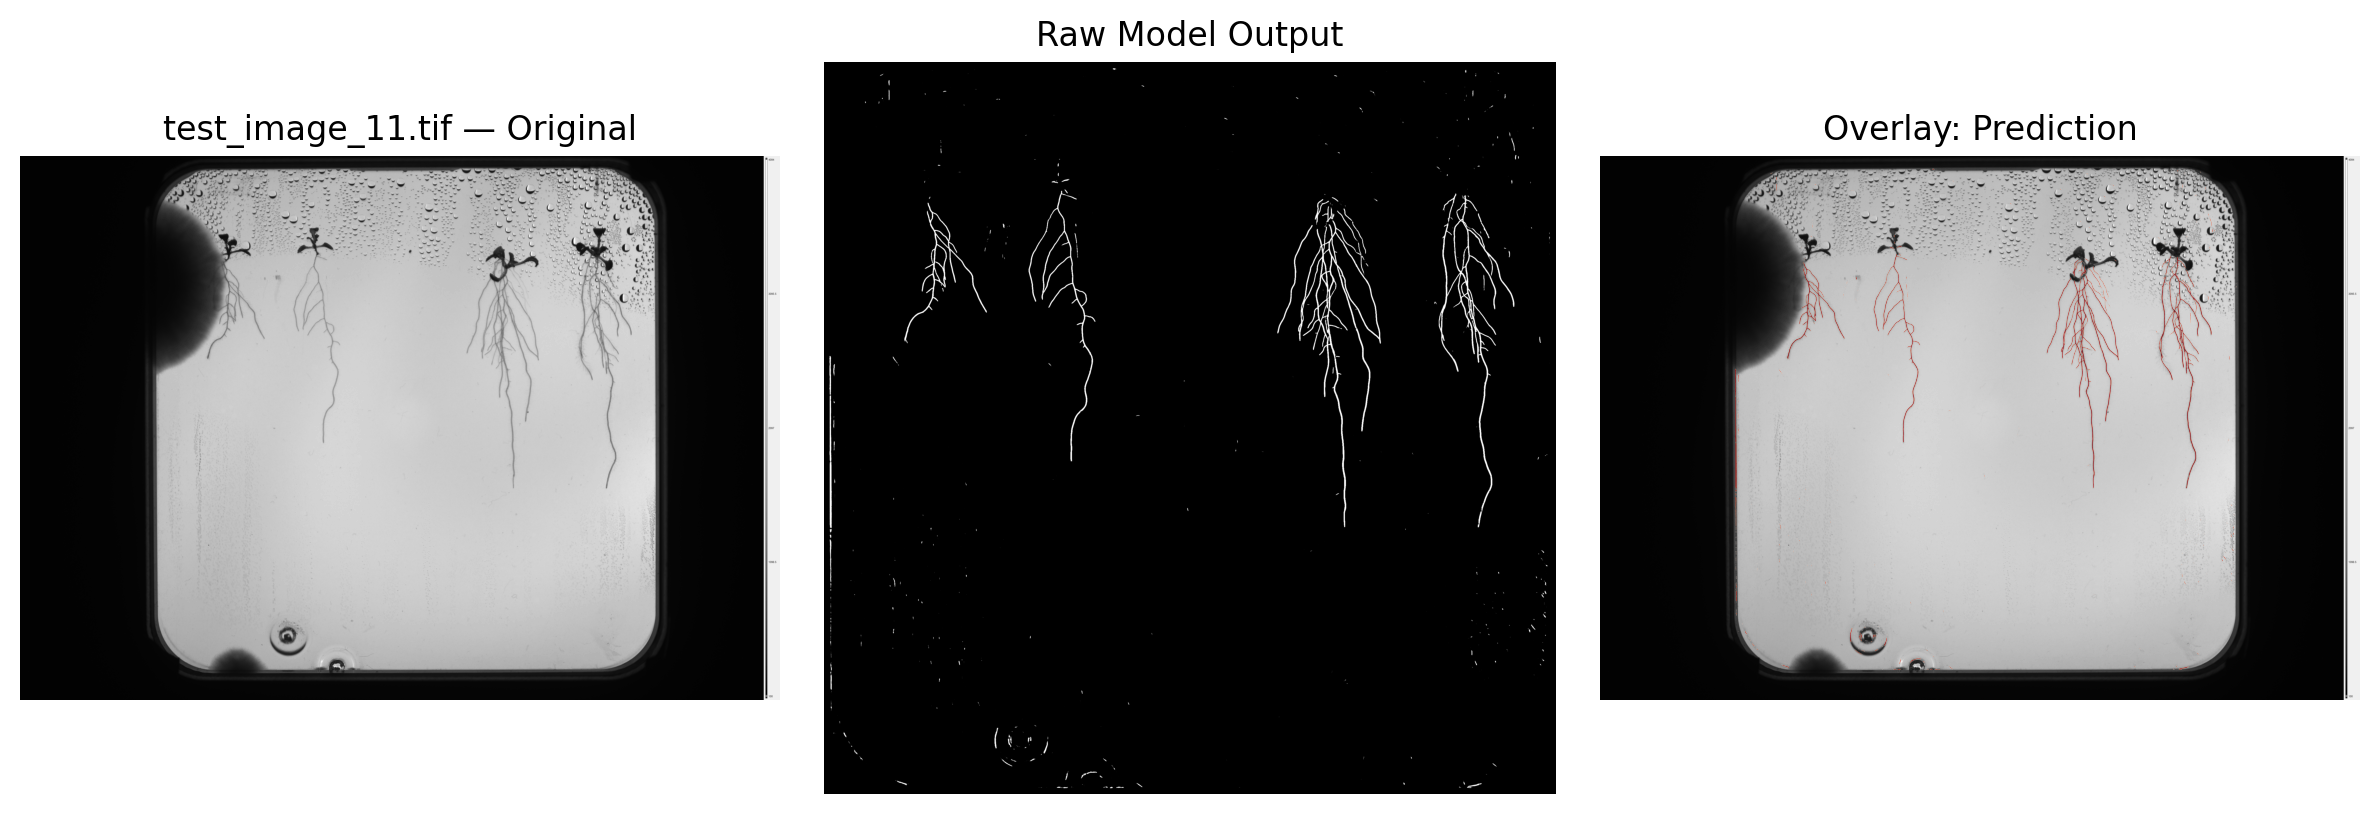


Processing test_image_2.tif


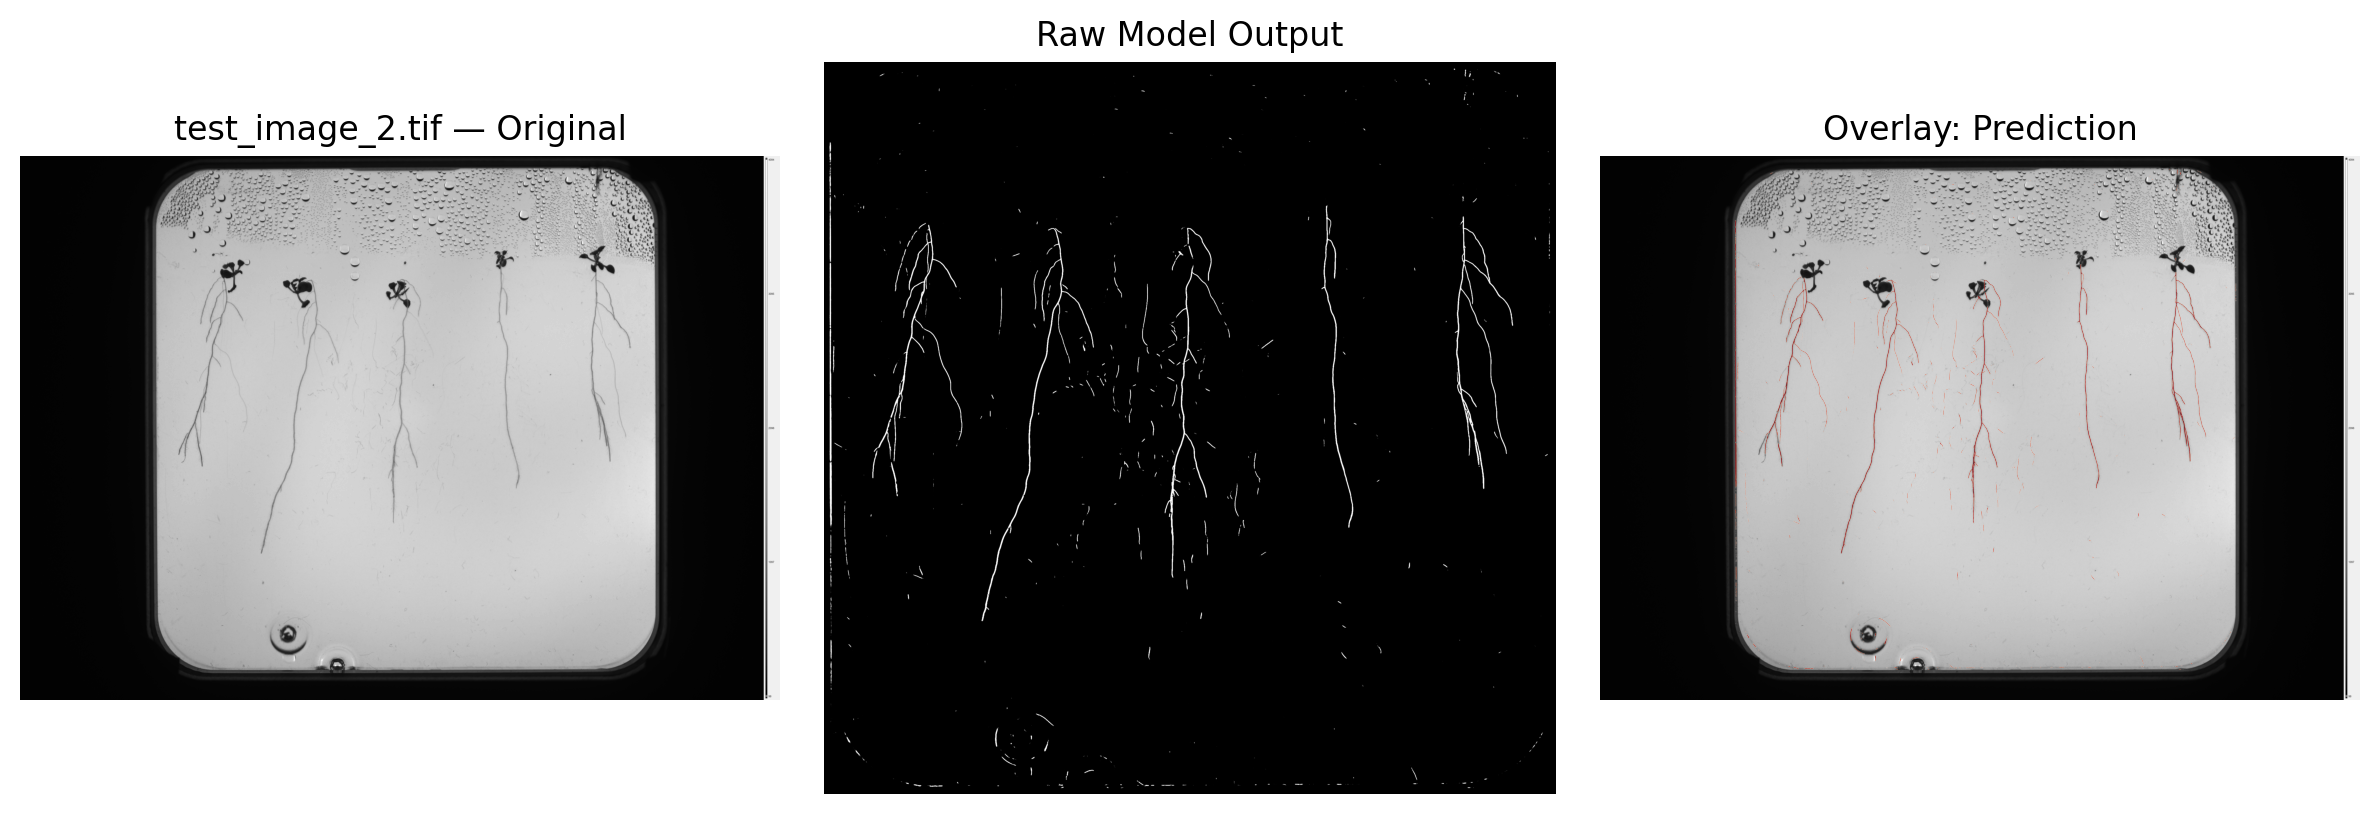


Processing test_image_3.tif


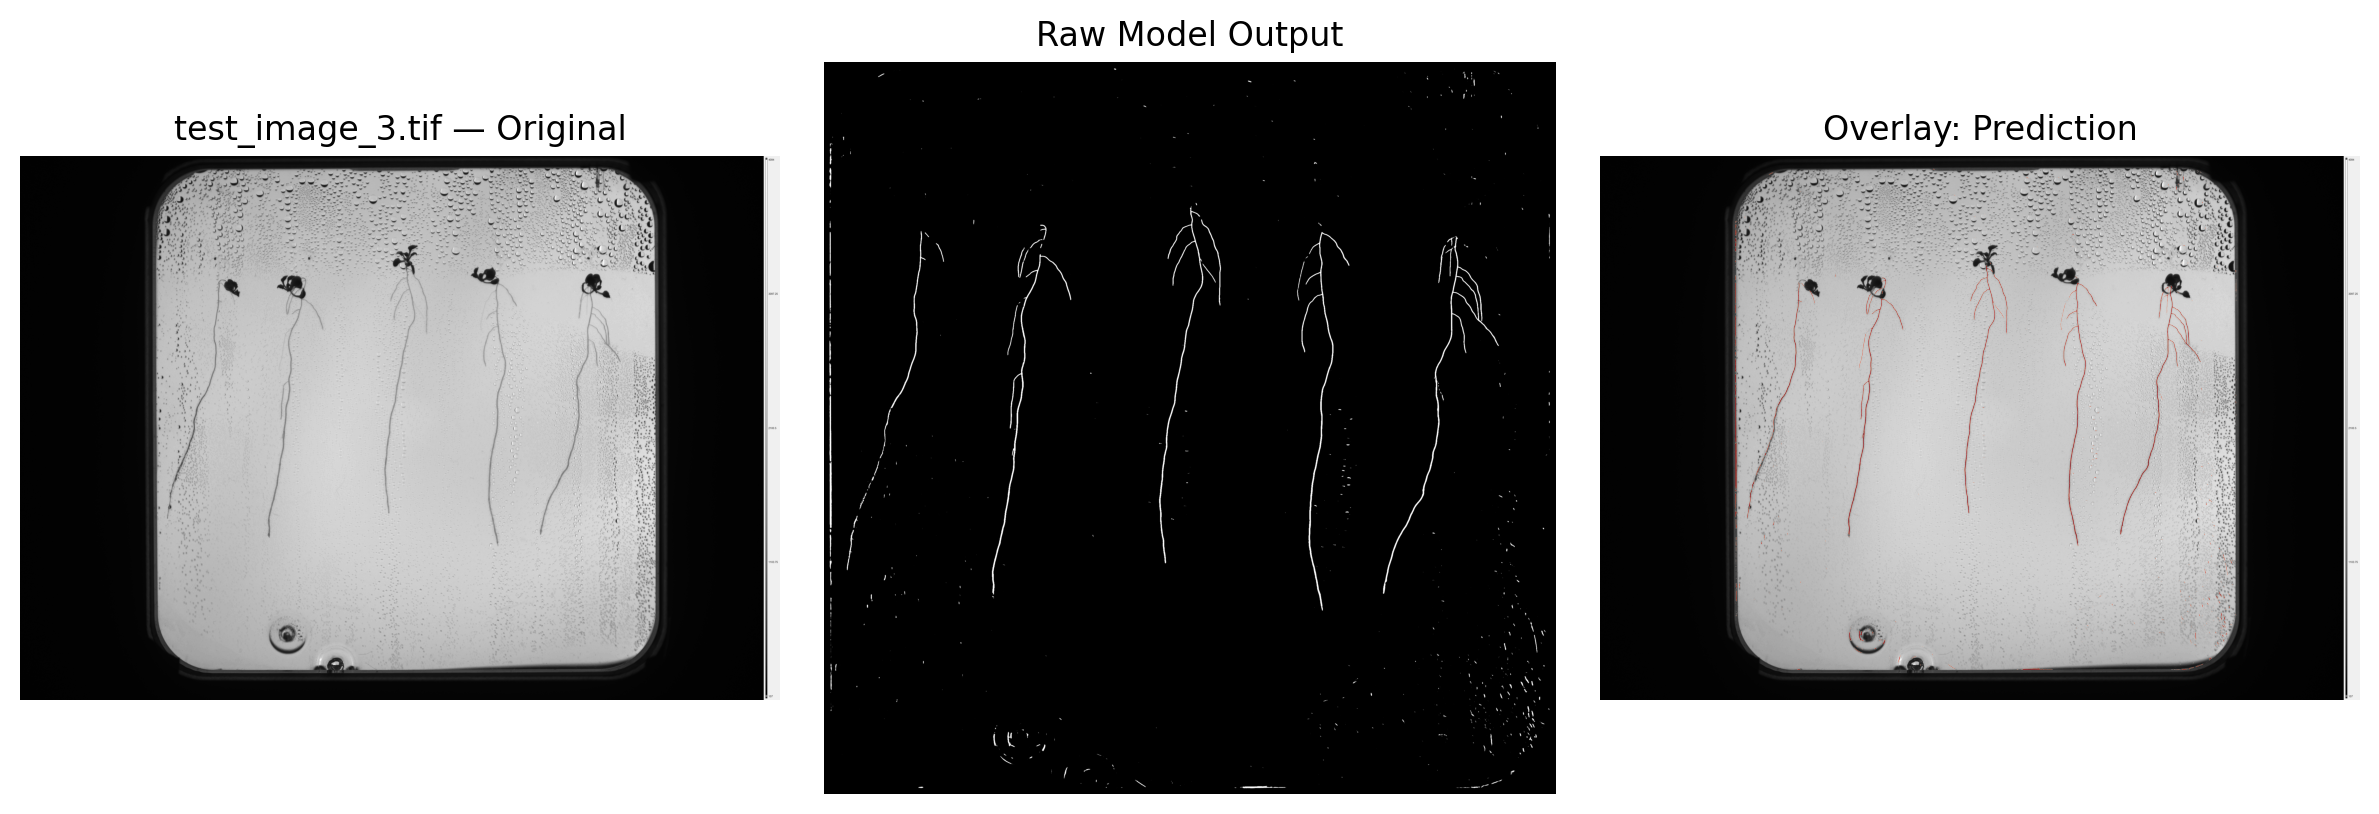


Processing test_image_4.tif


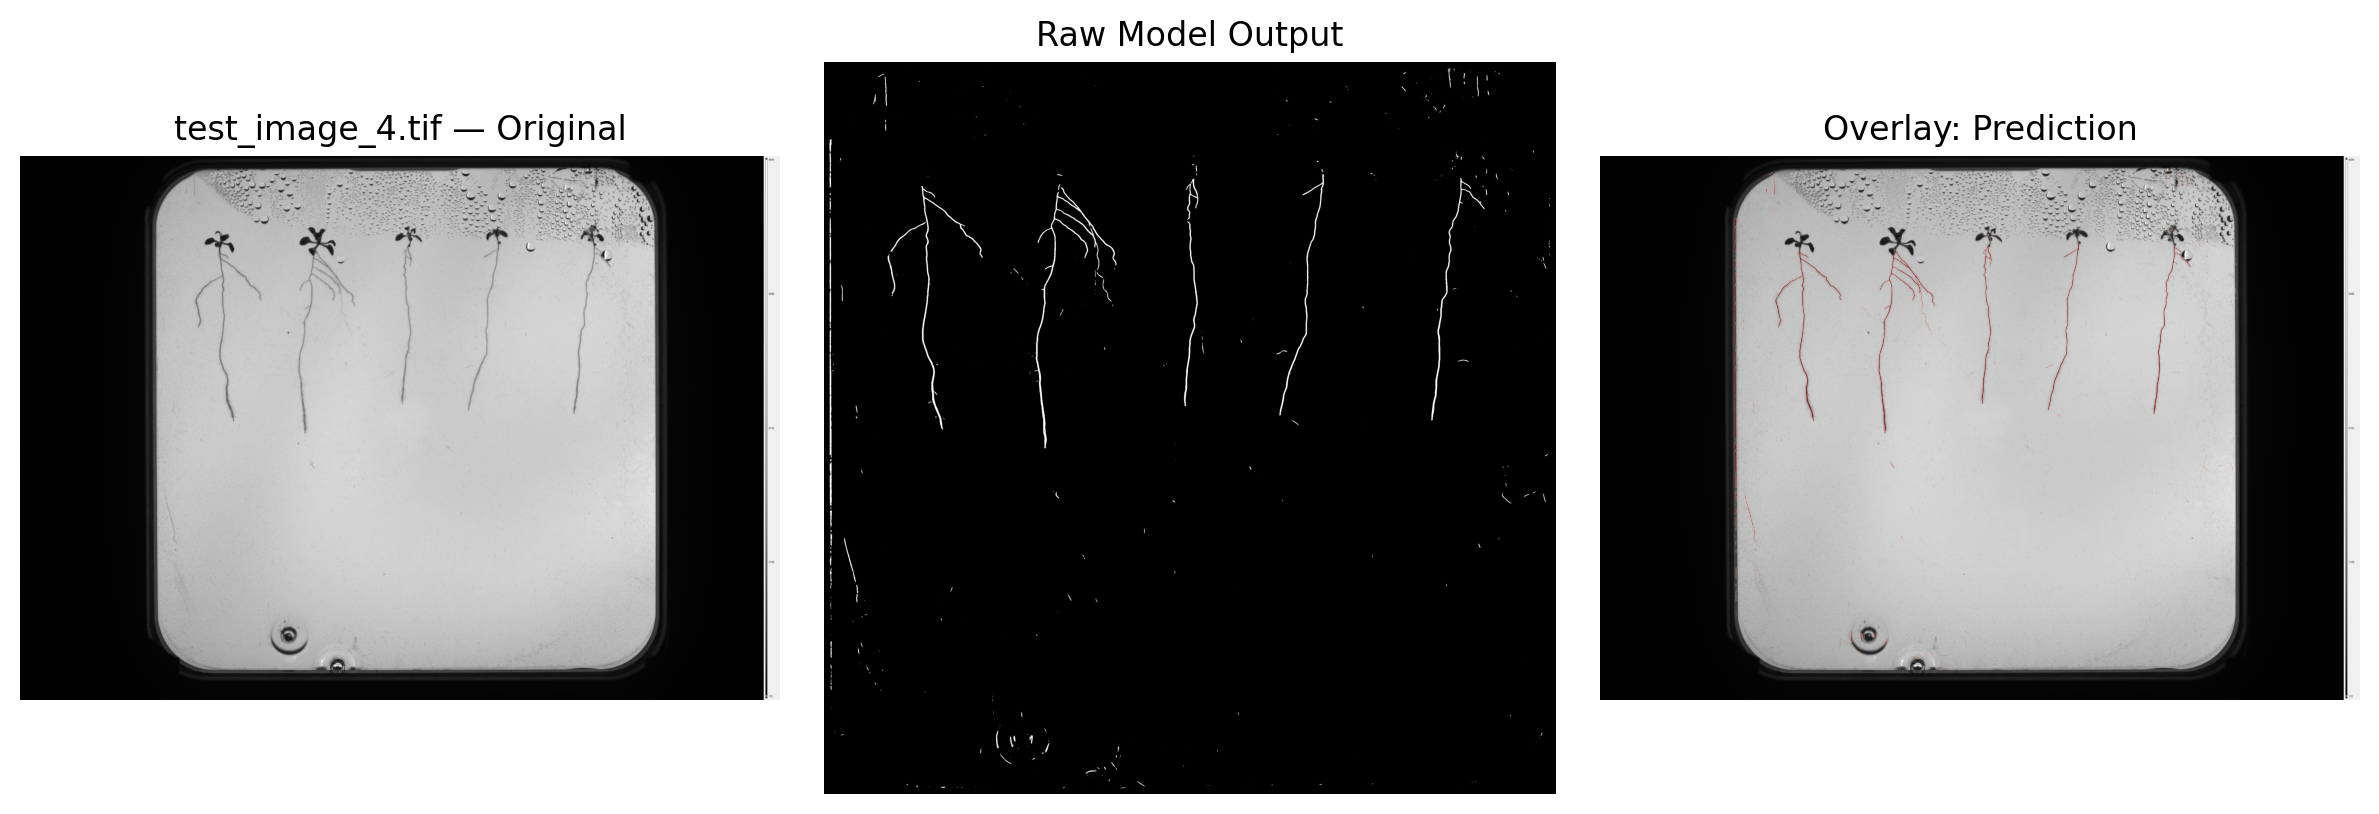


Processing test_image_5.tif


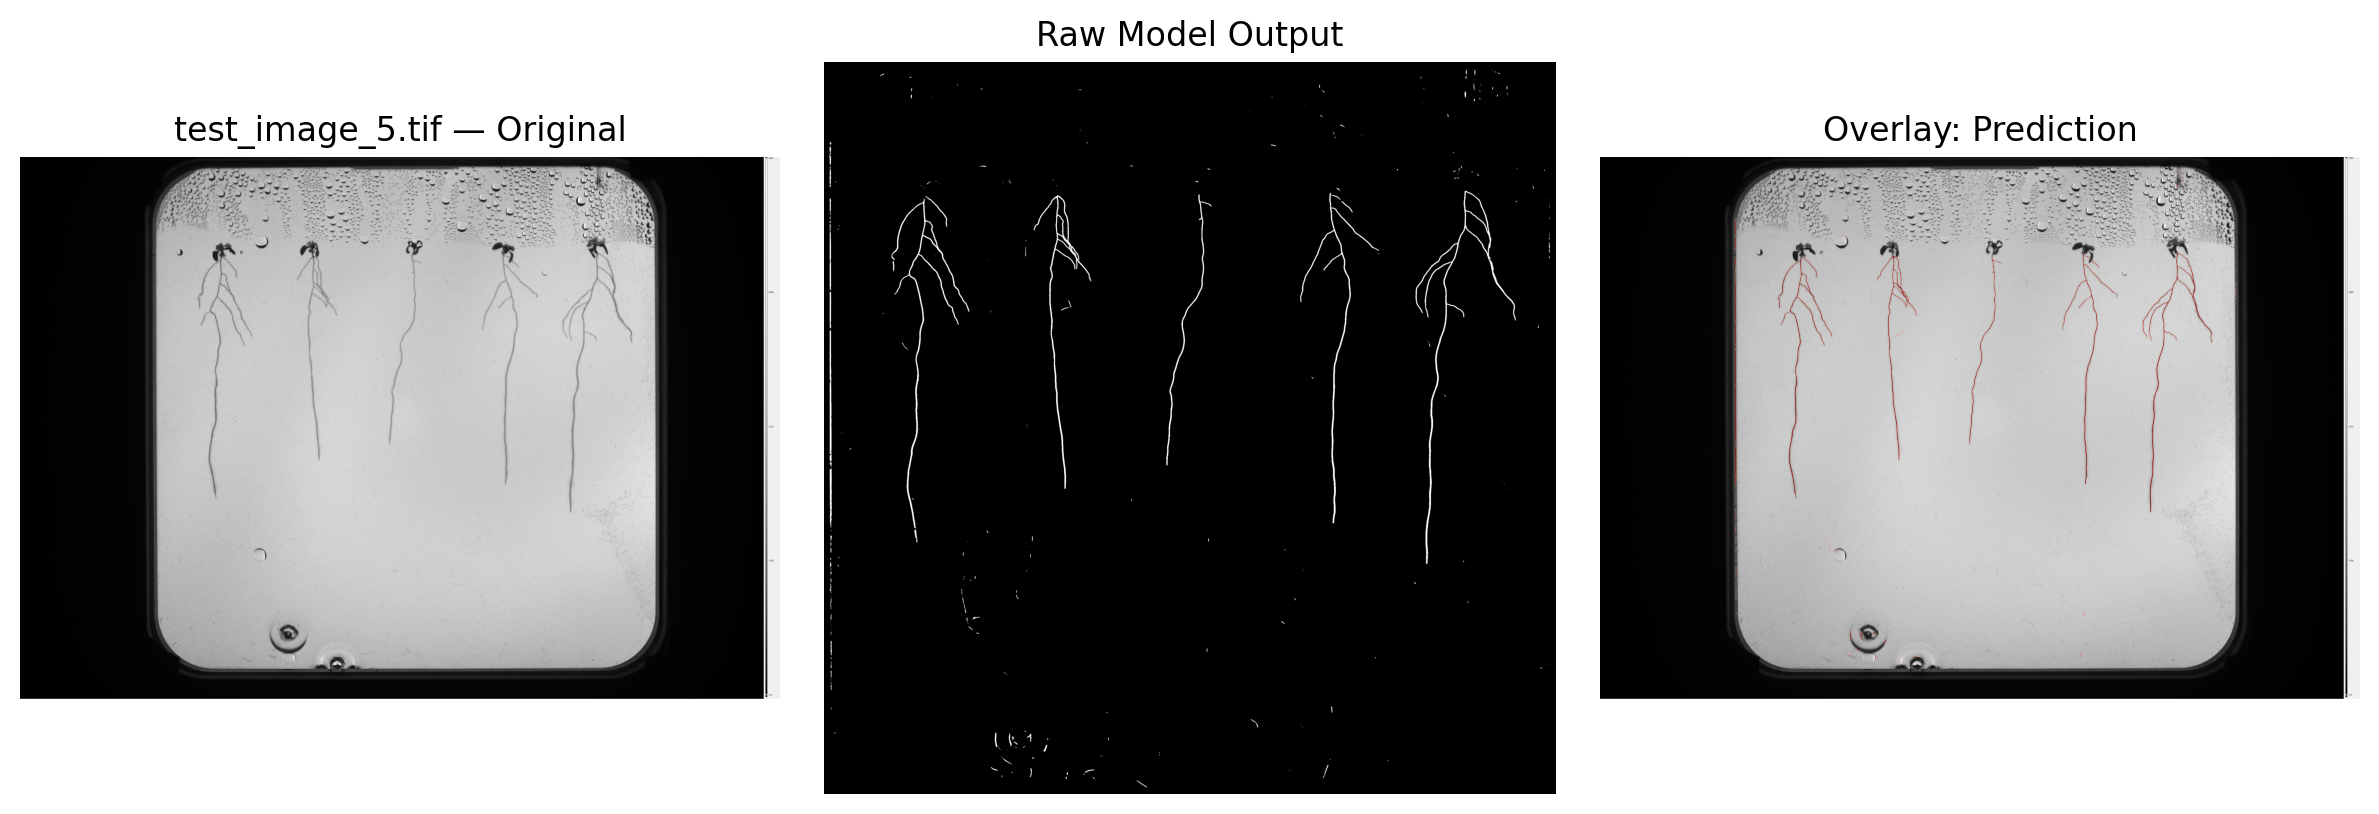


Processing test_image_6.tif


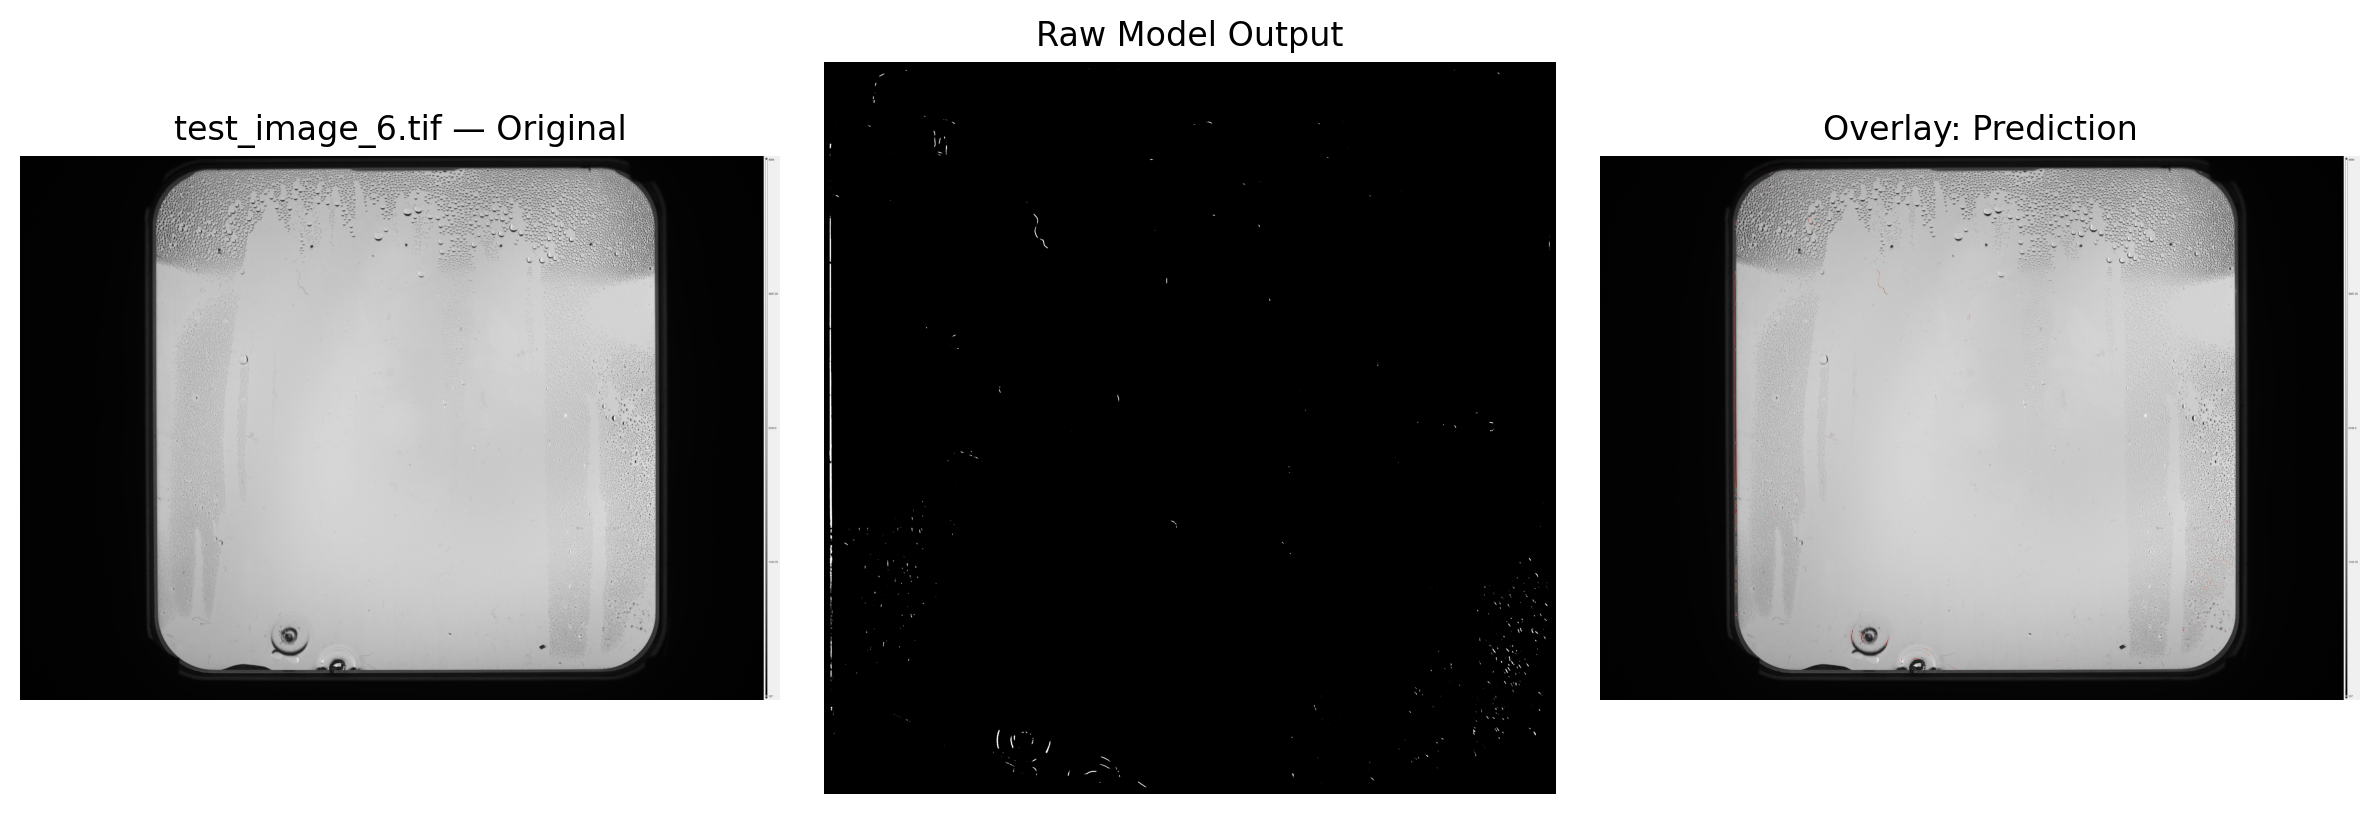


Processing test_image_7.tif


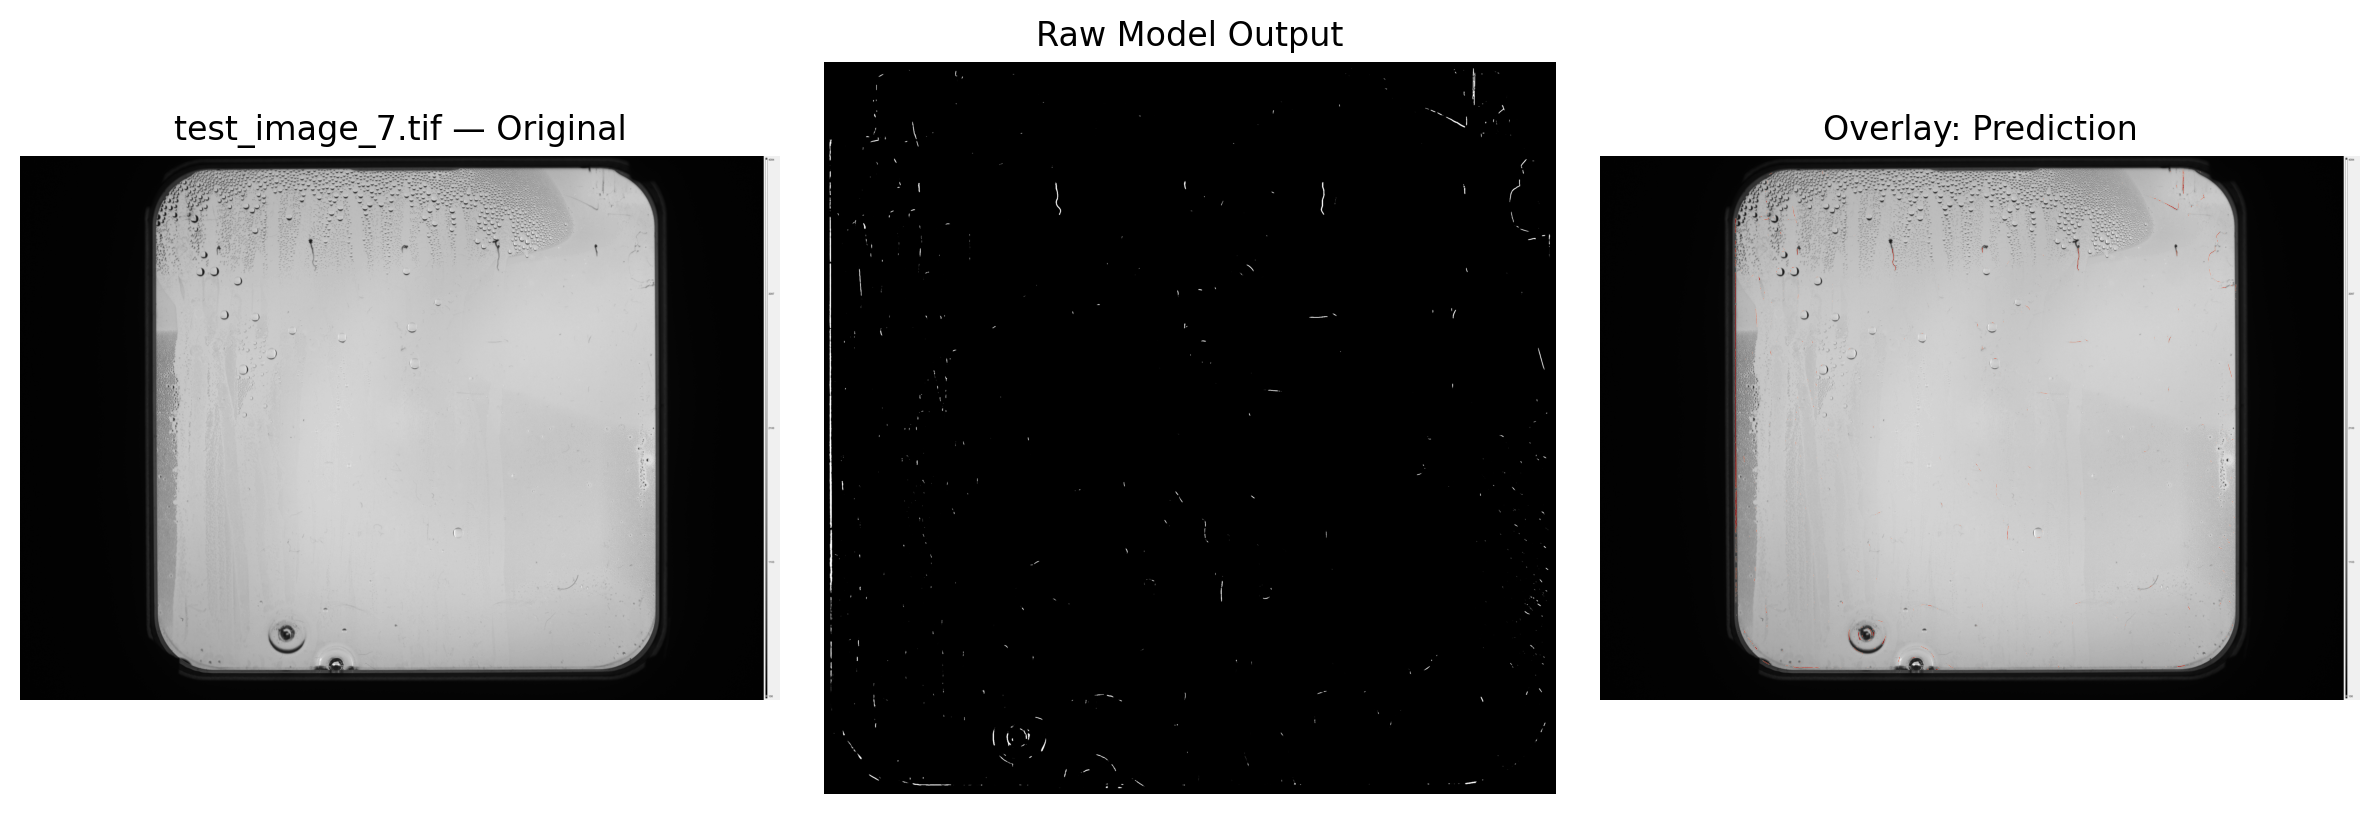


Processing test_image_8.tif


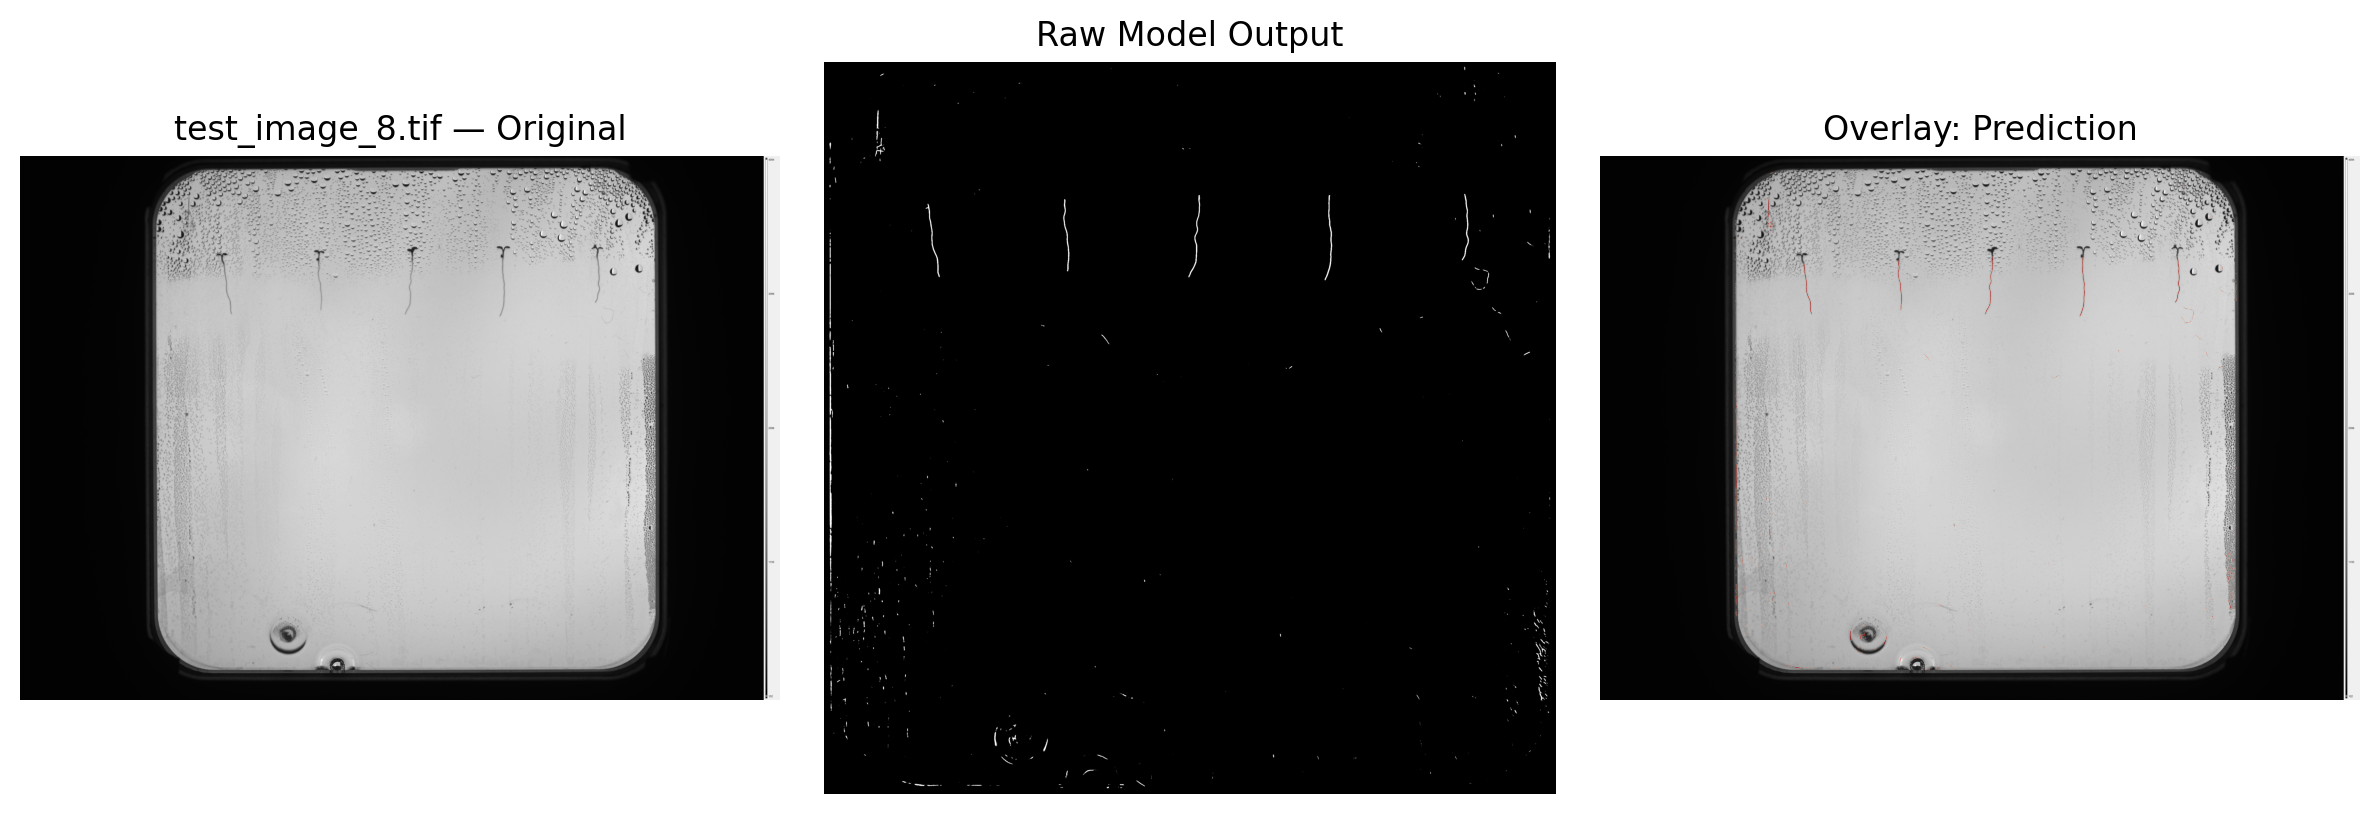


Processing test_image_9.tif


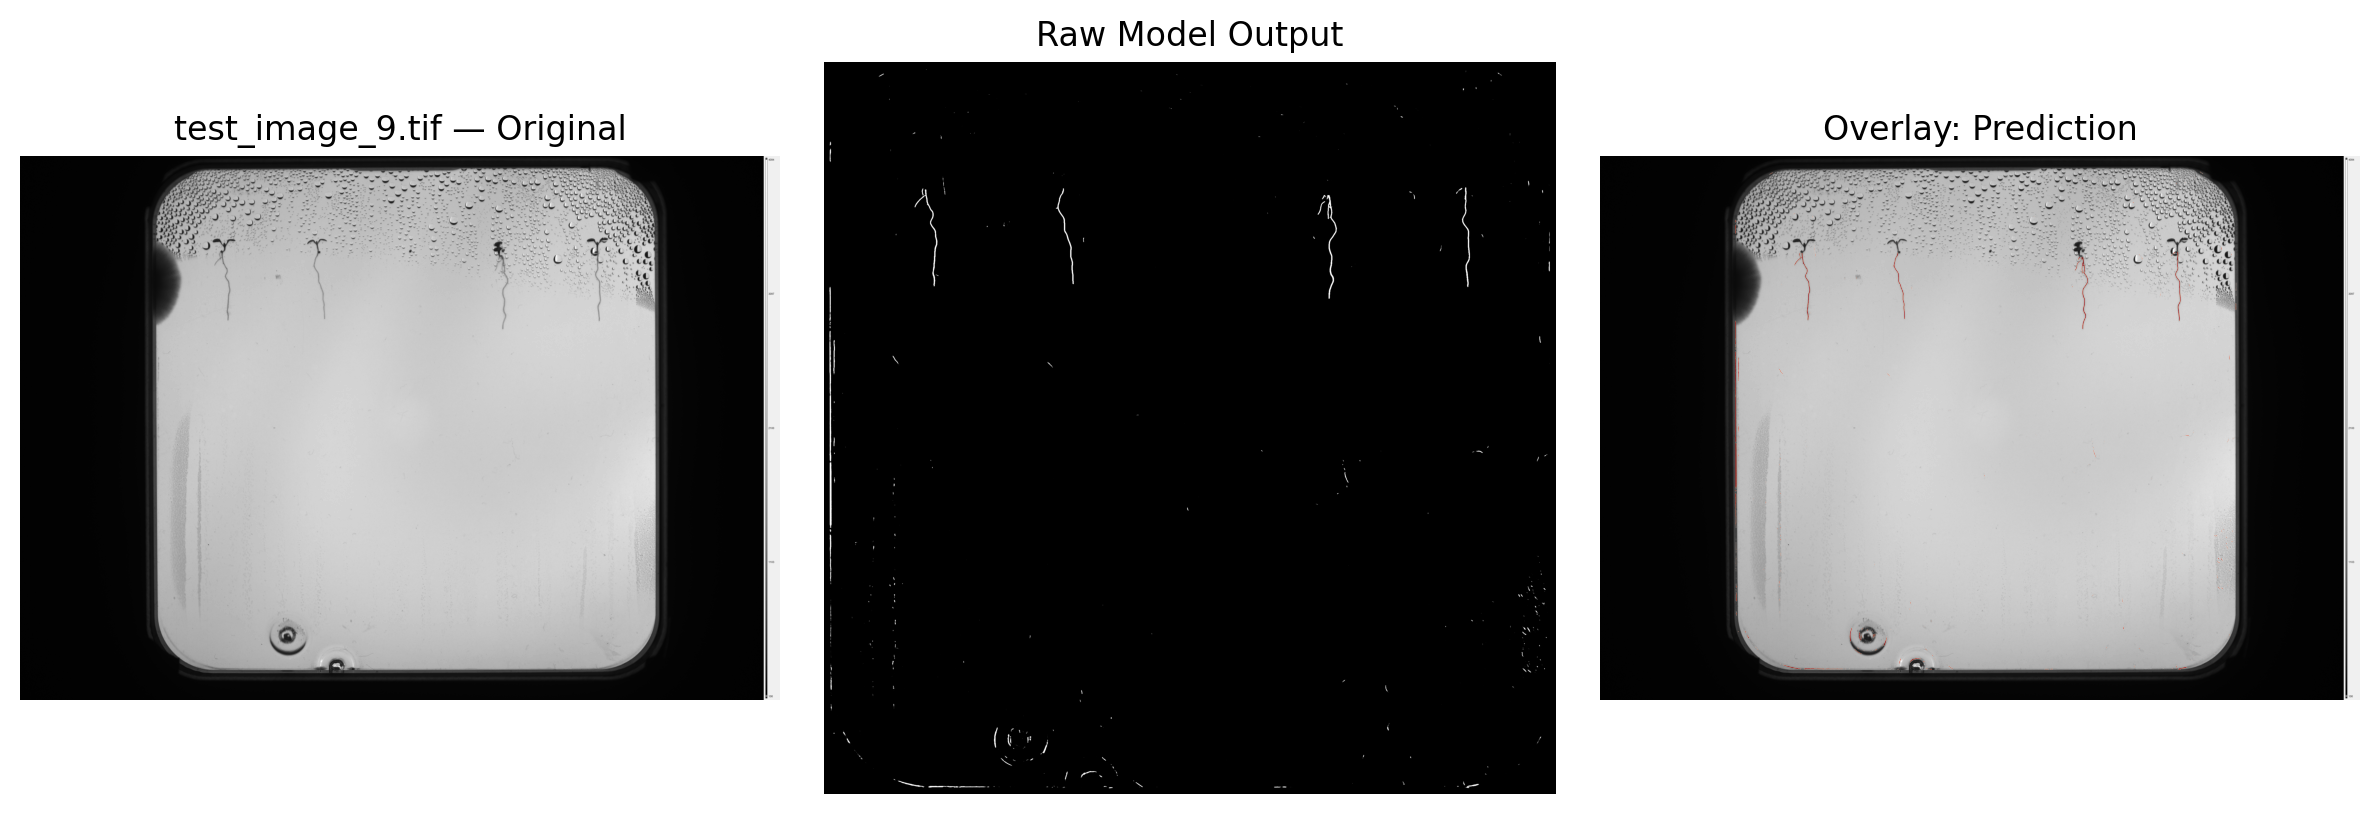

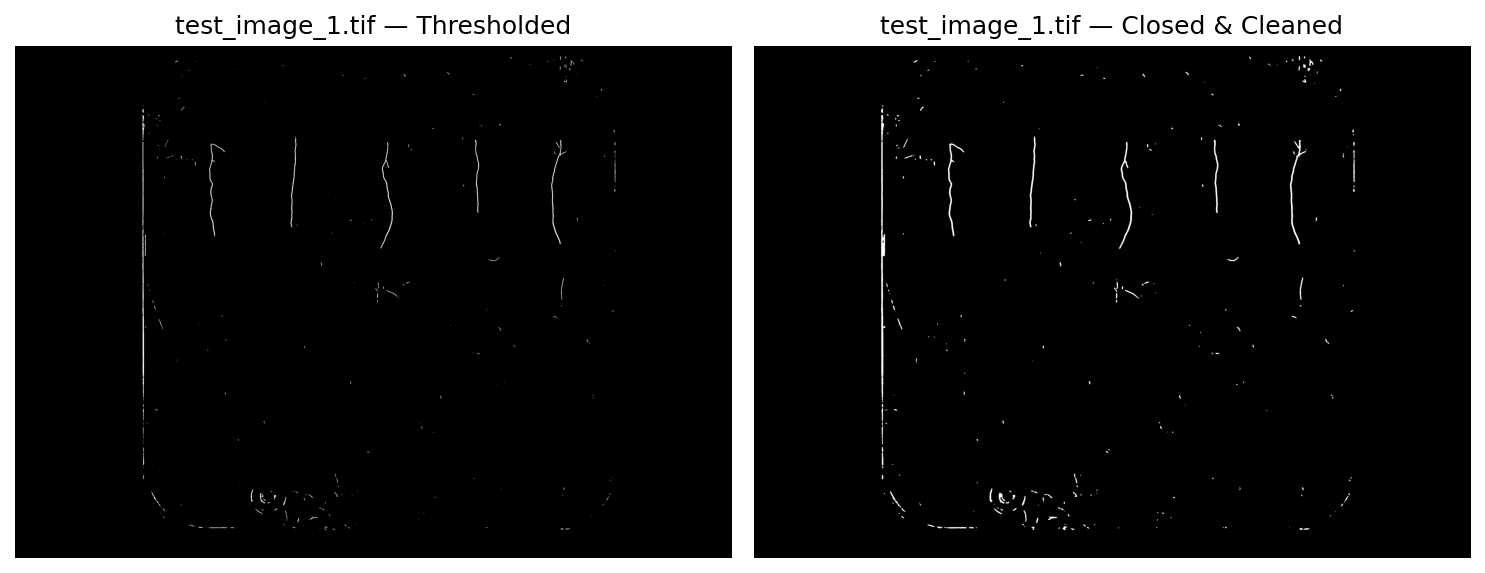

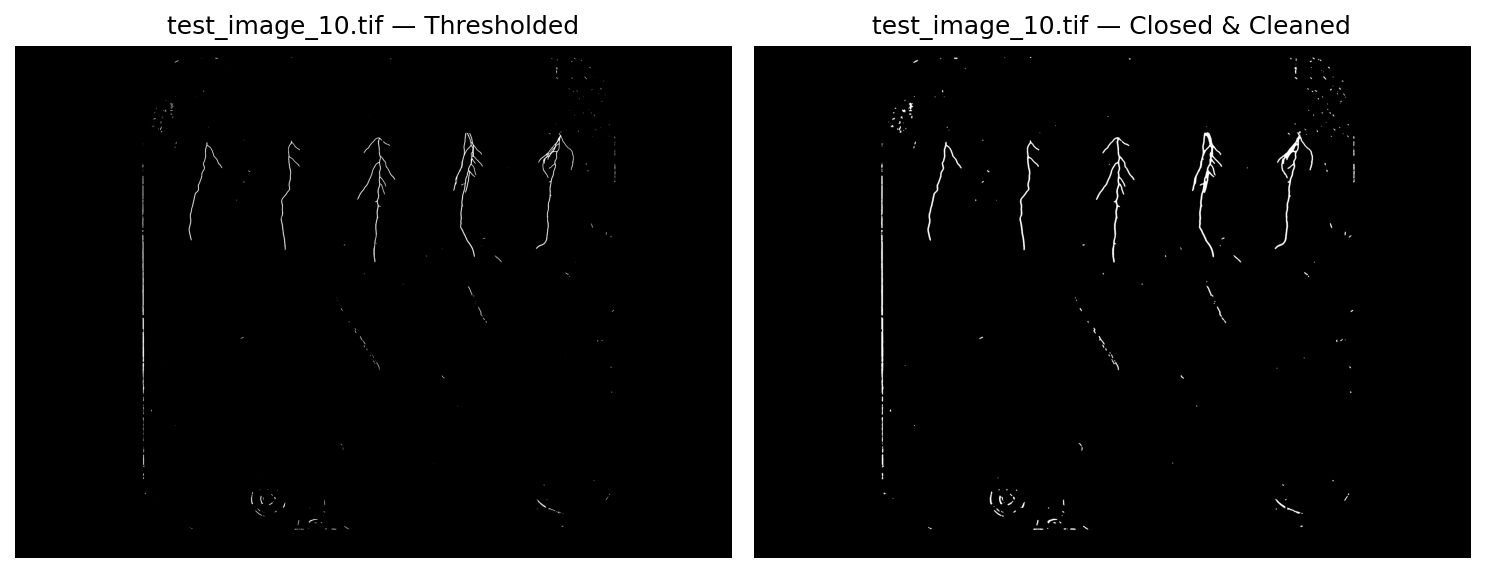

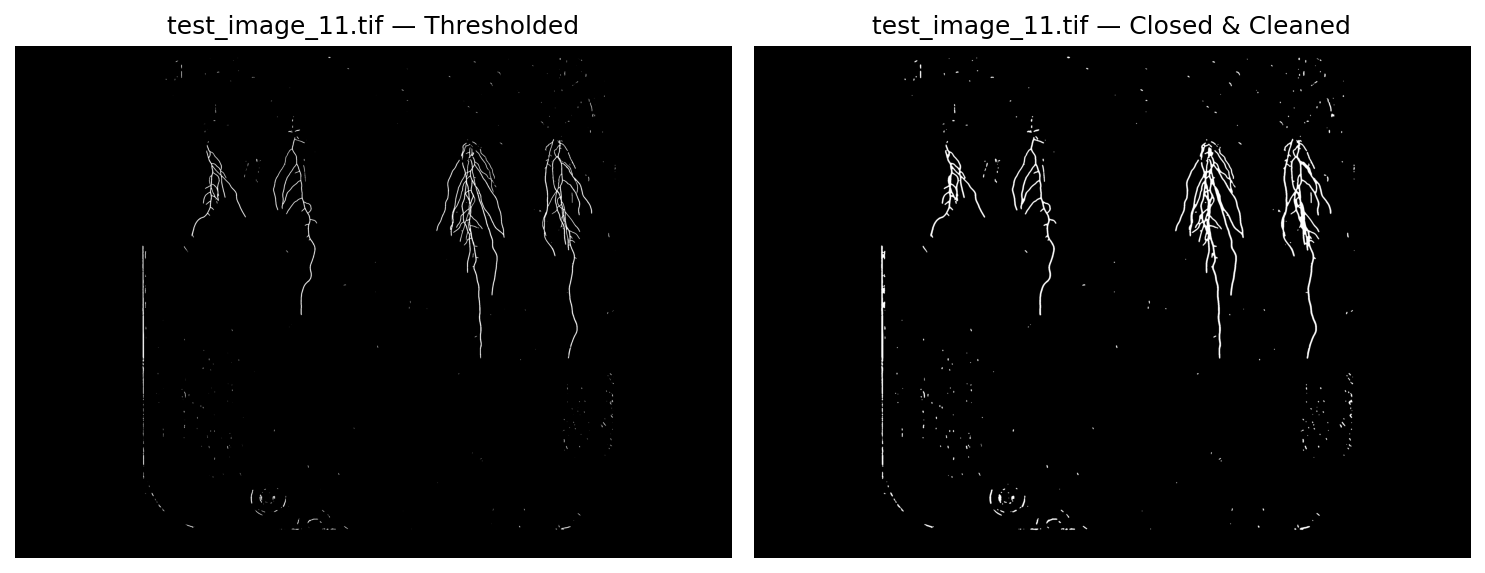

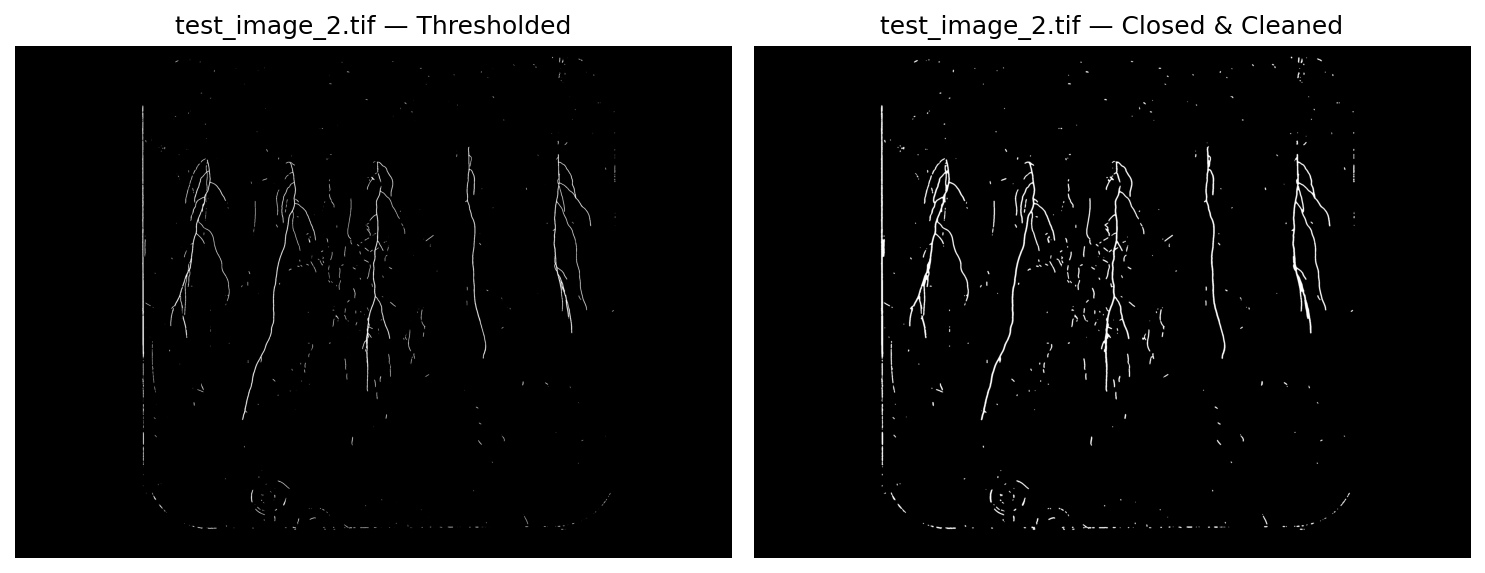

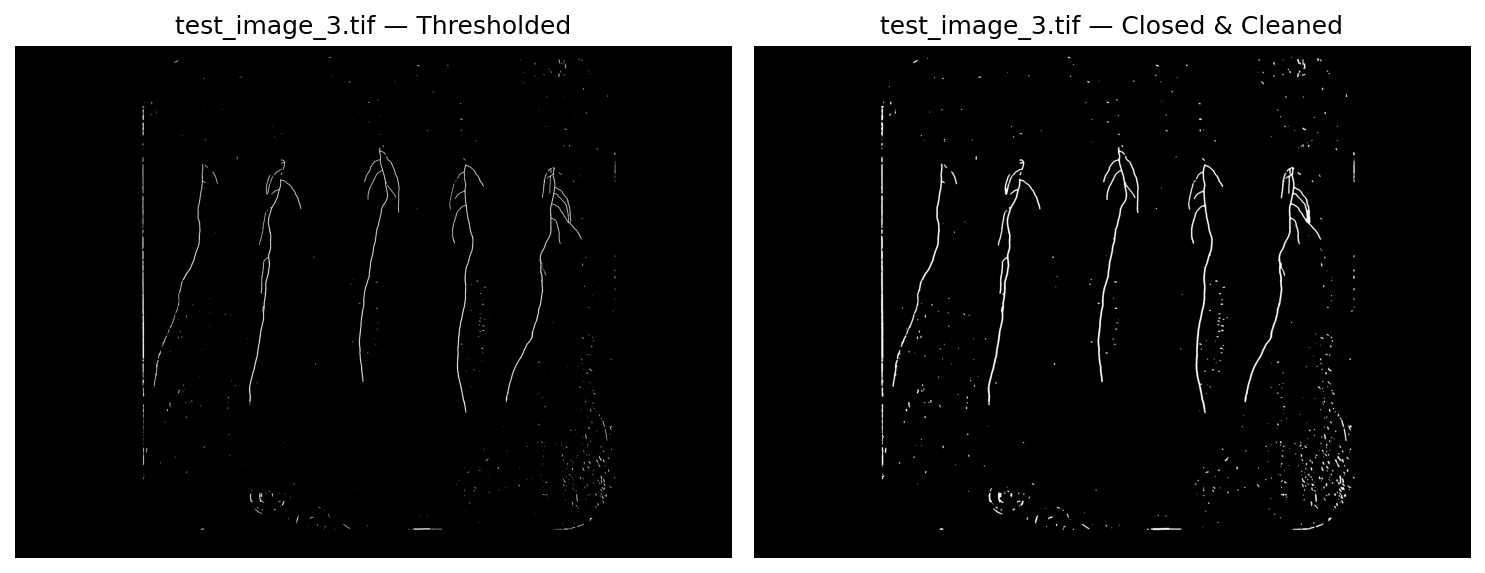

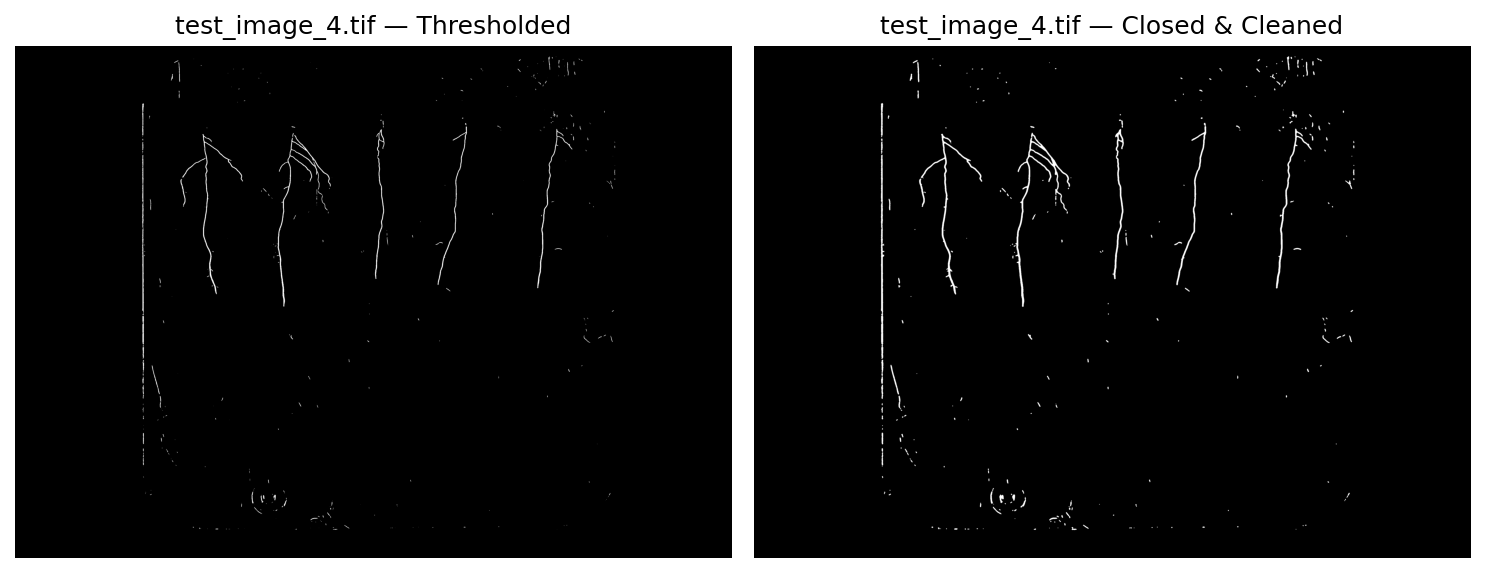

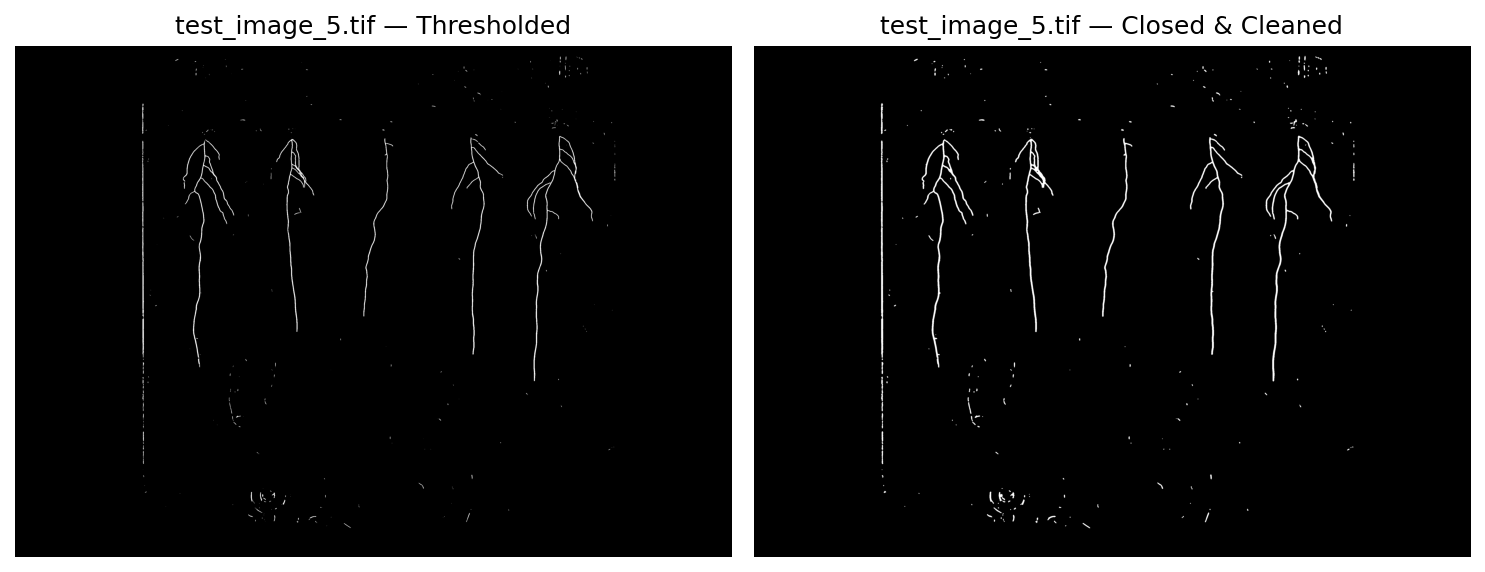

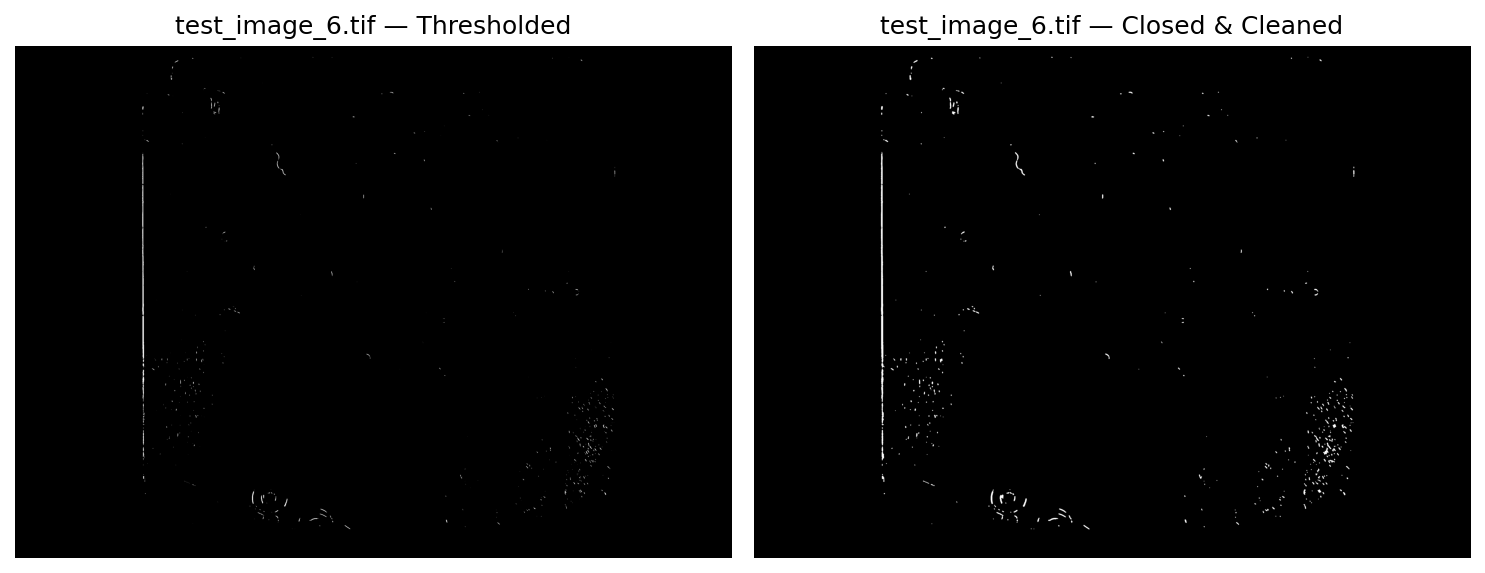

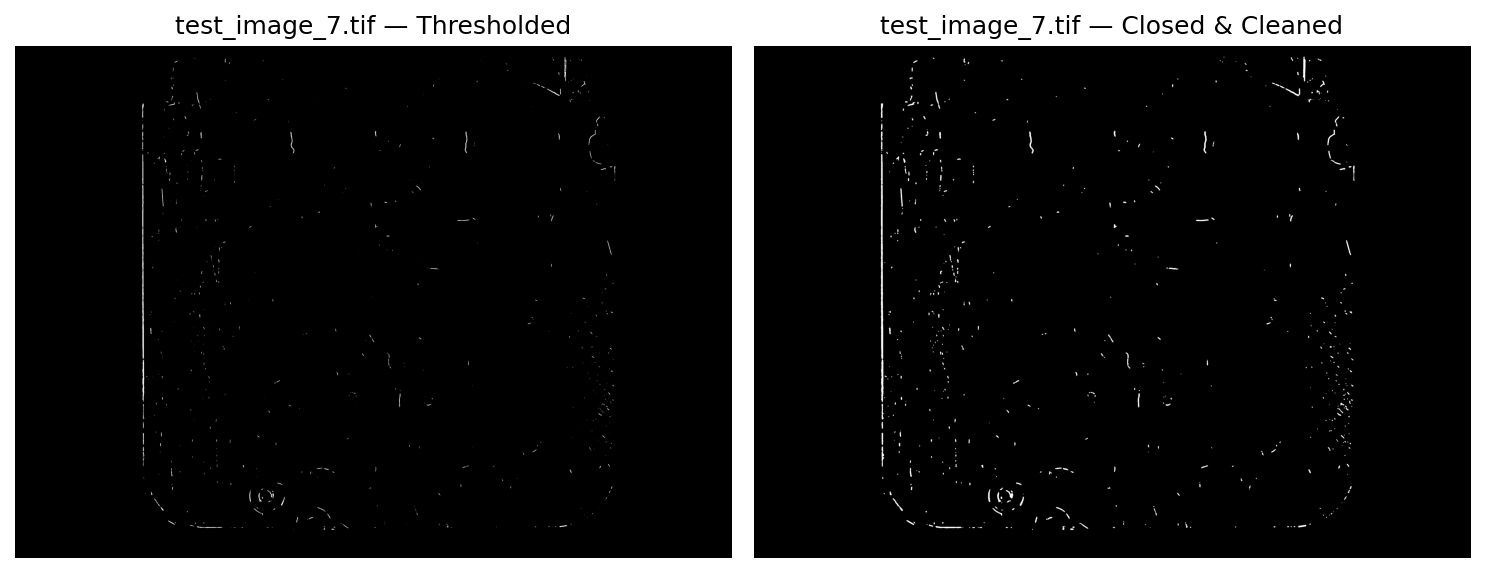

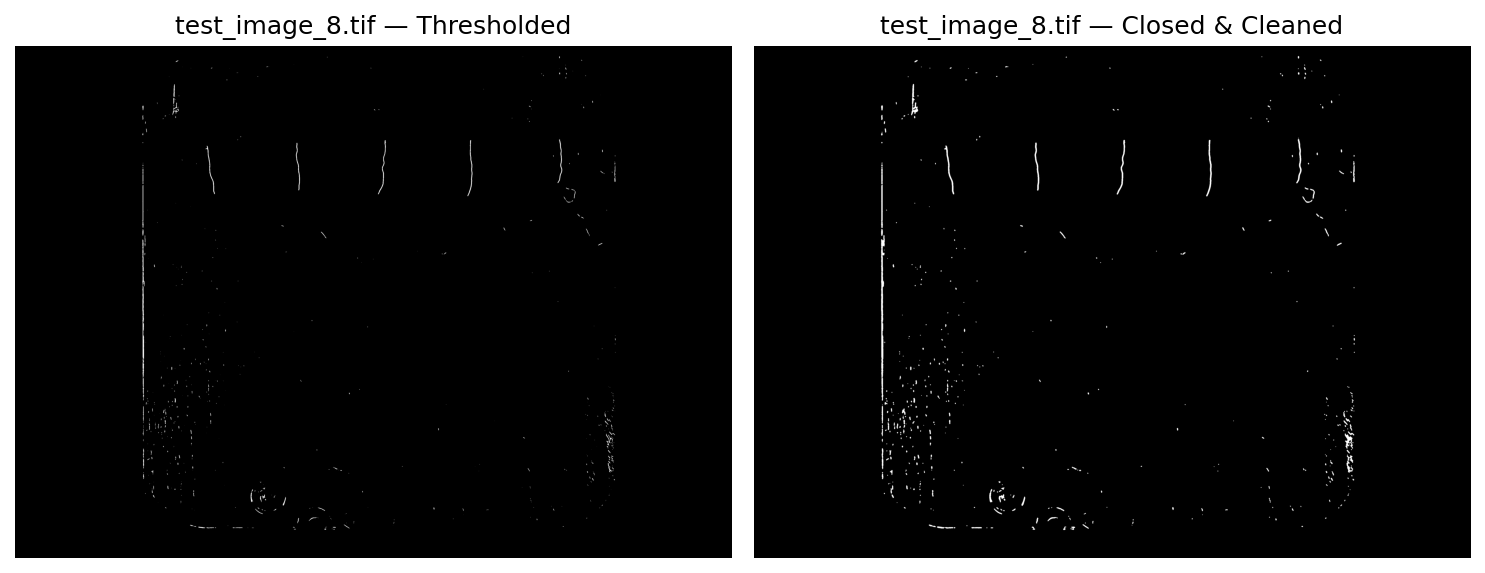

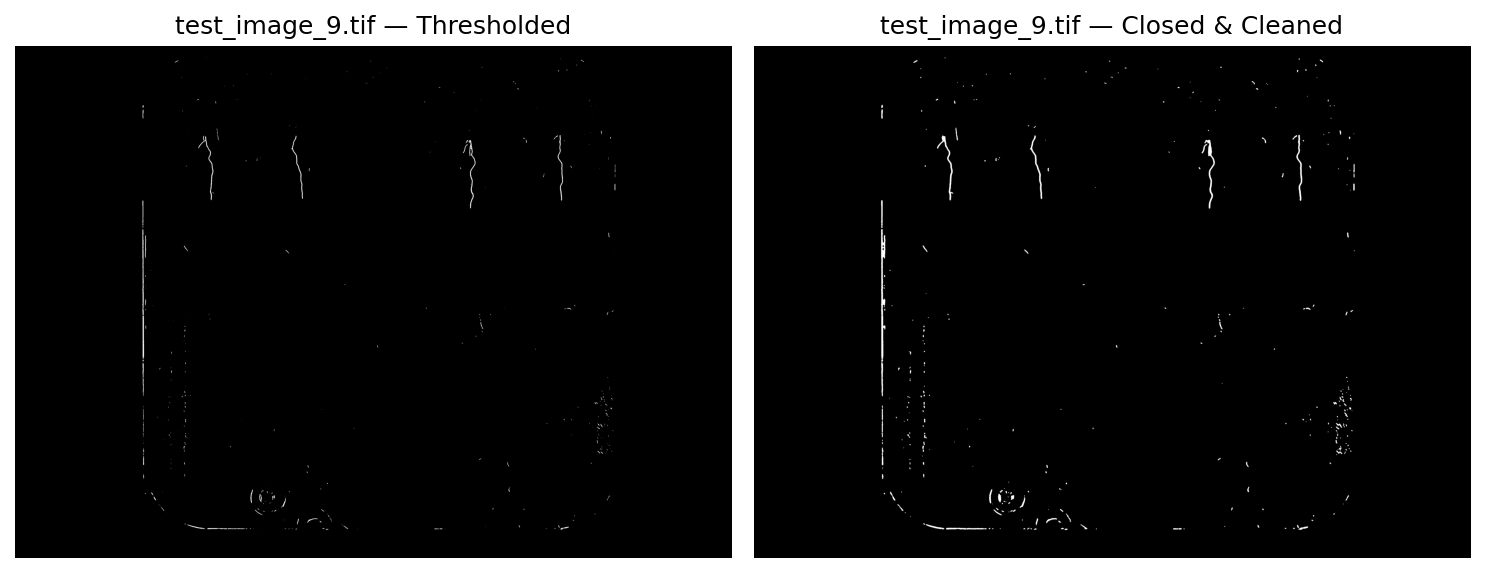

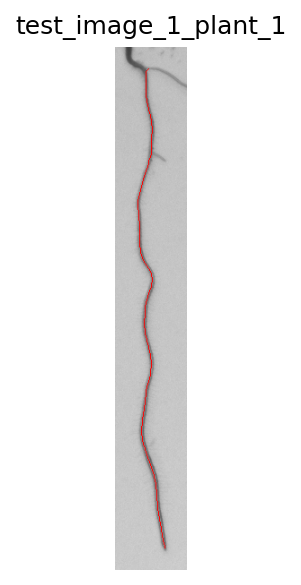

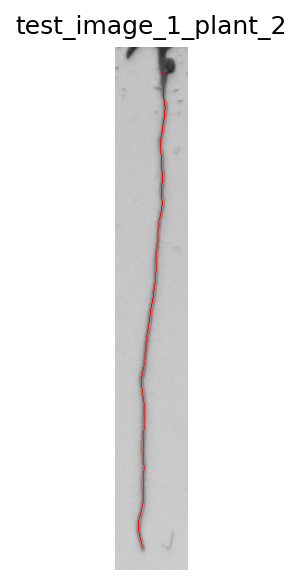

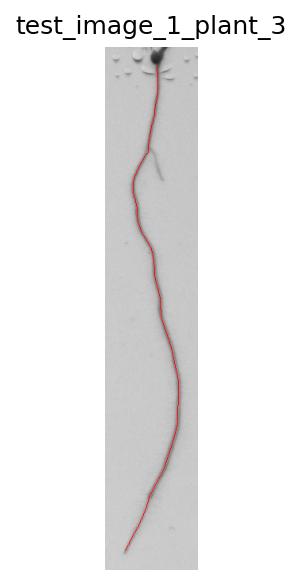

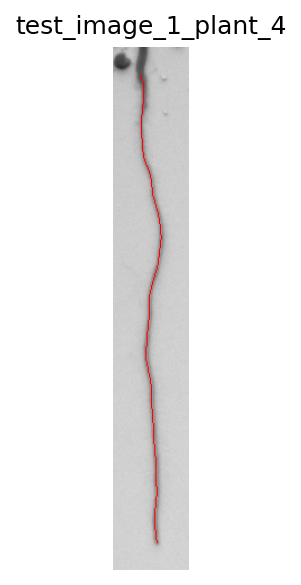

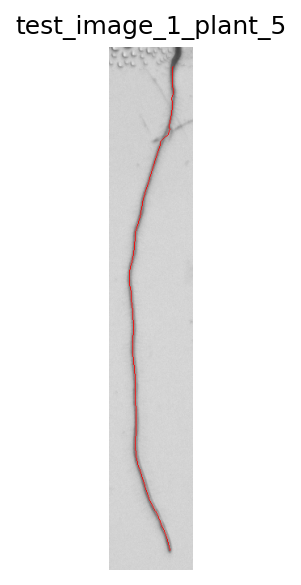

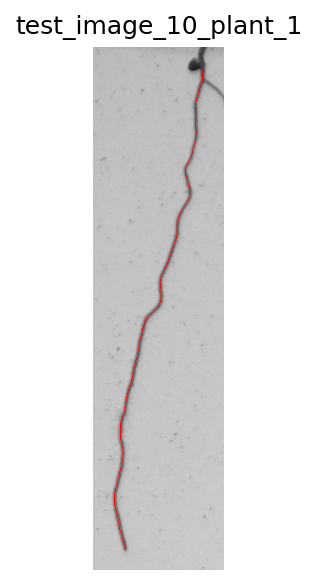

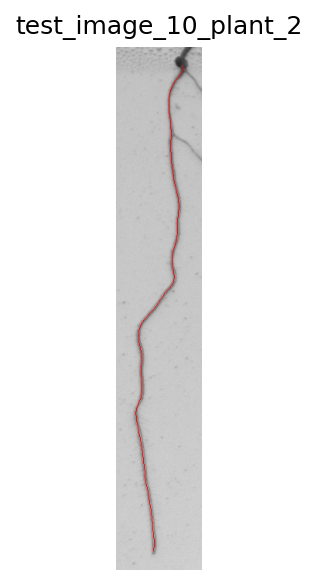

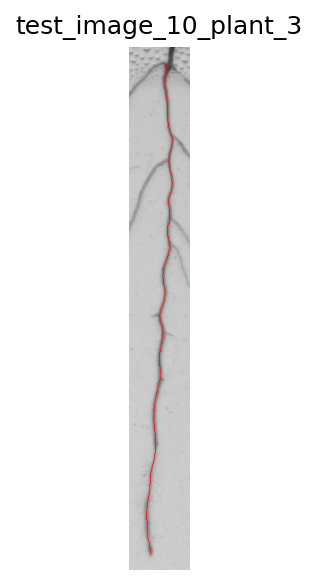

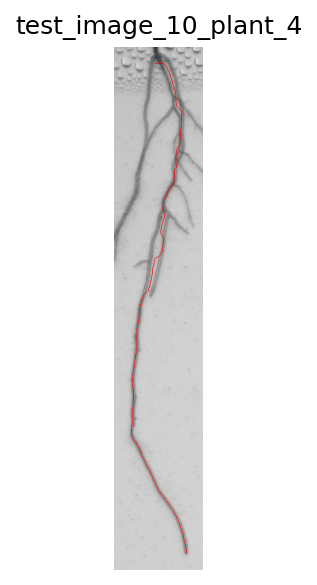

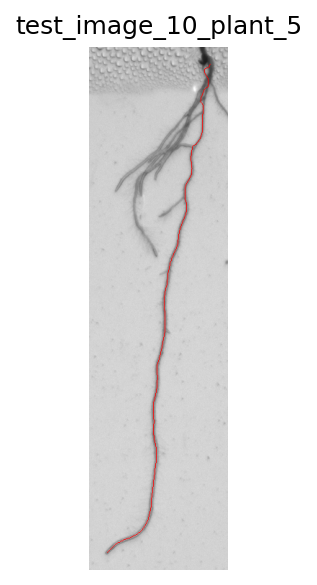

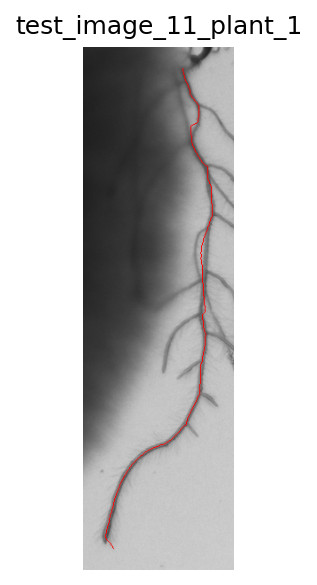

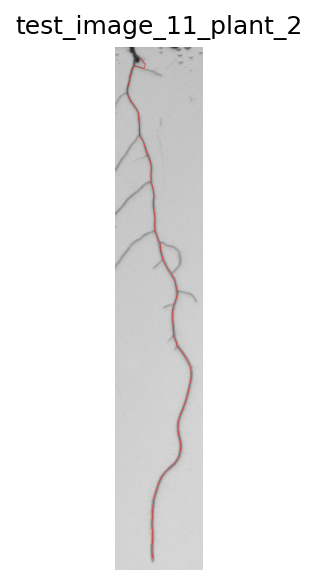

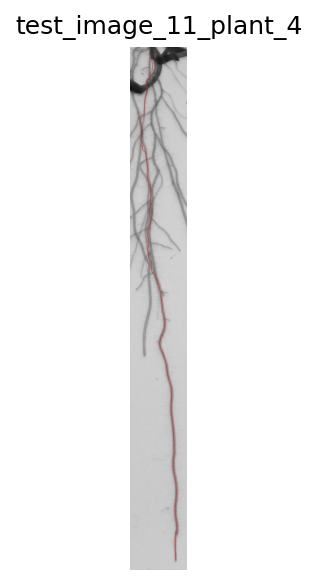

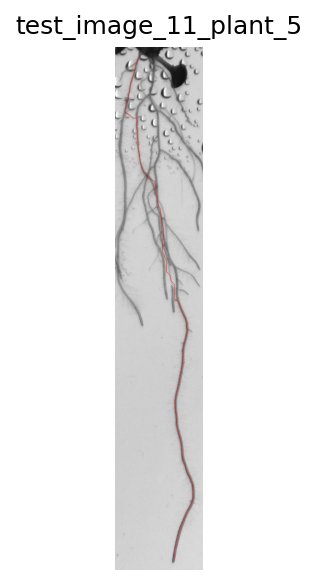

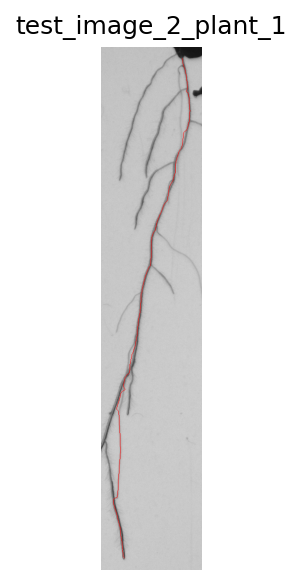

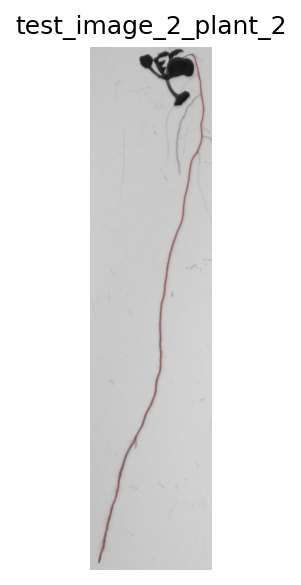

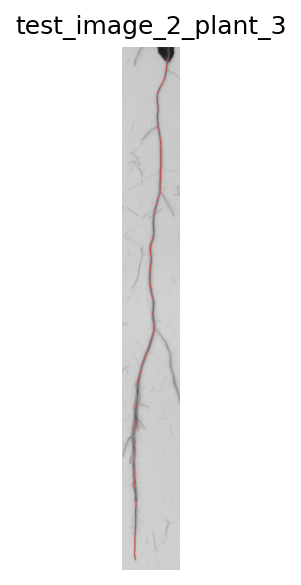

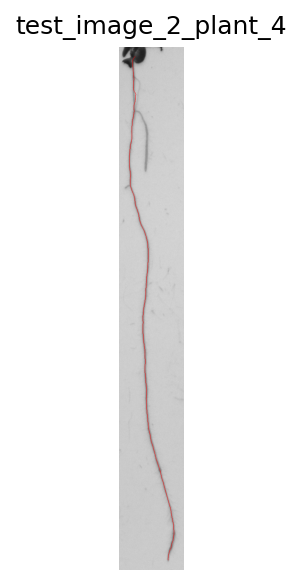

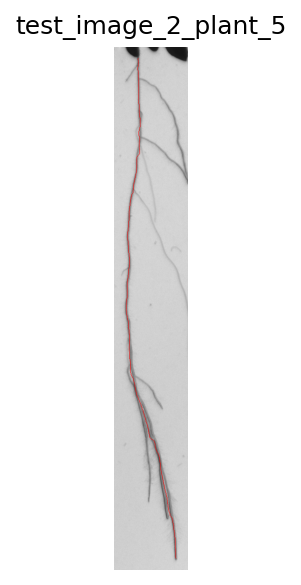

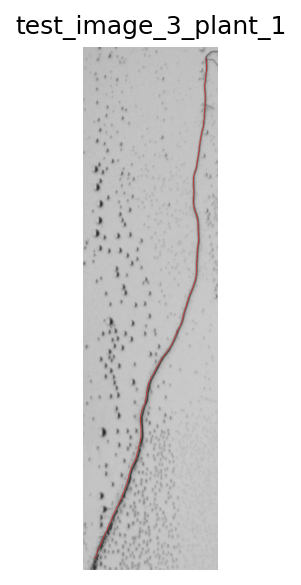

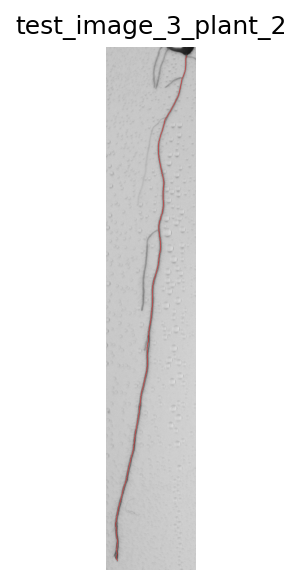

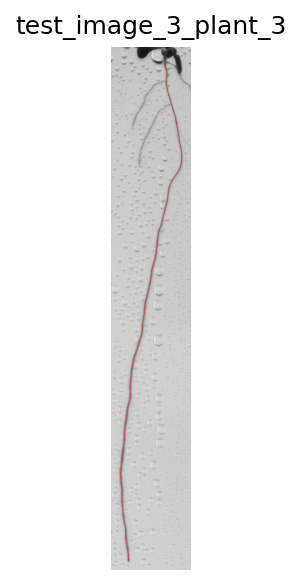

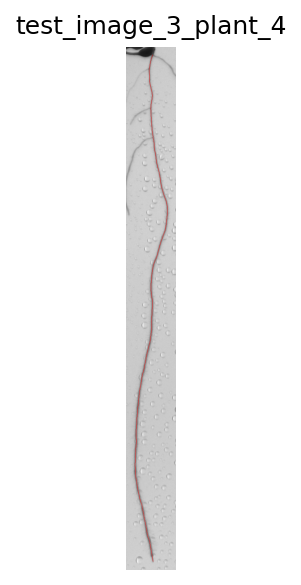

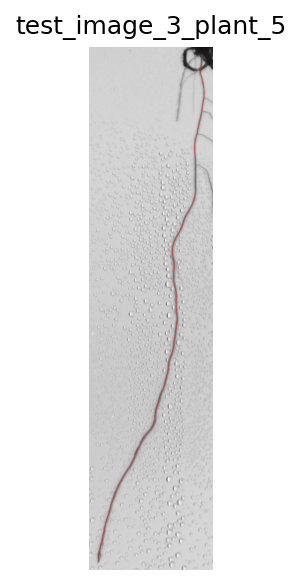

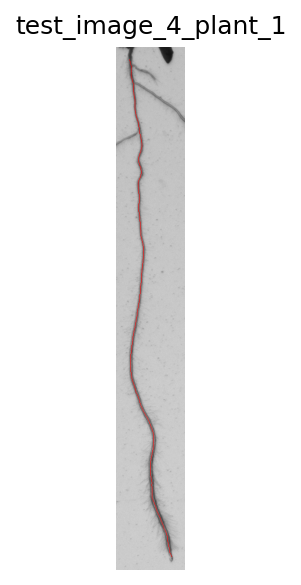

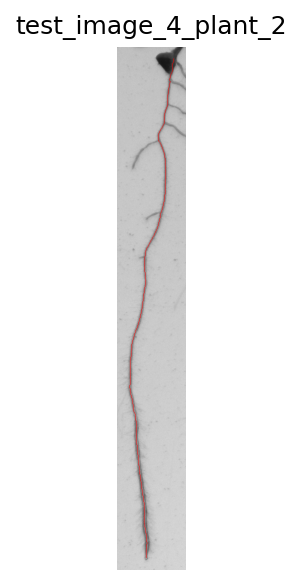

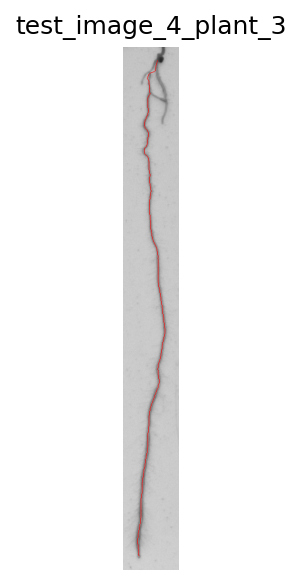

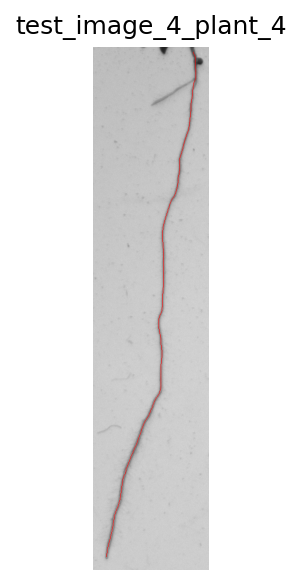

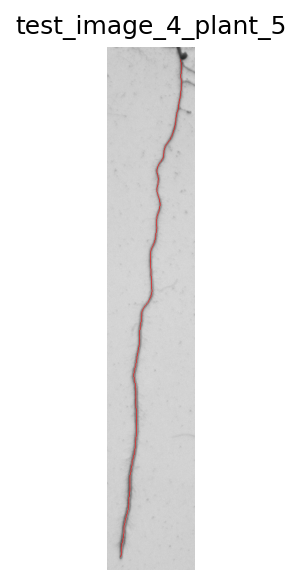

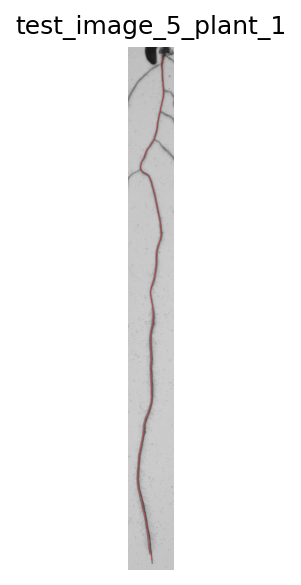

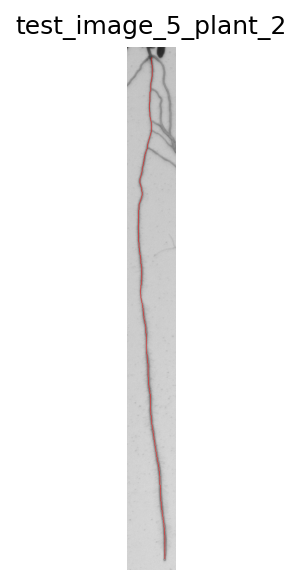

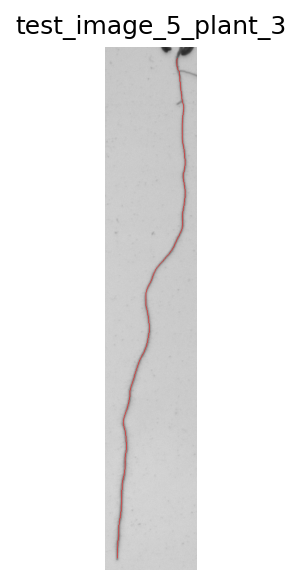

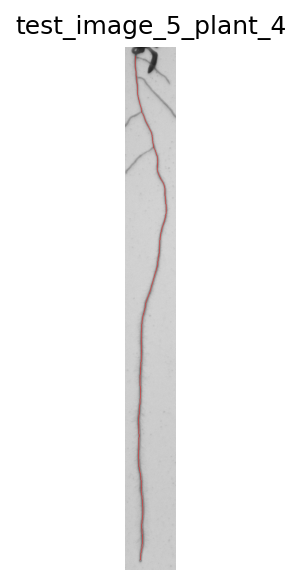

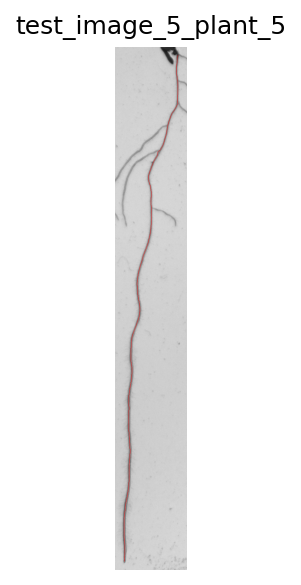

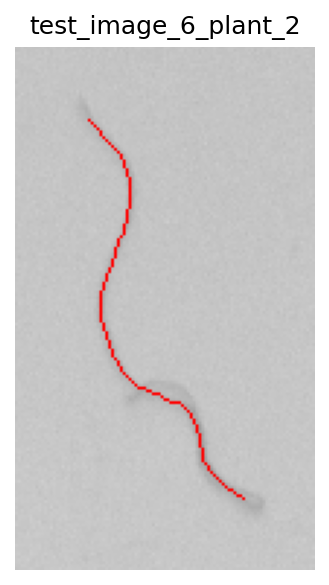

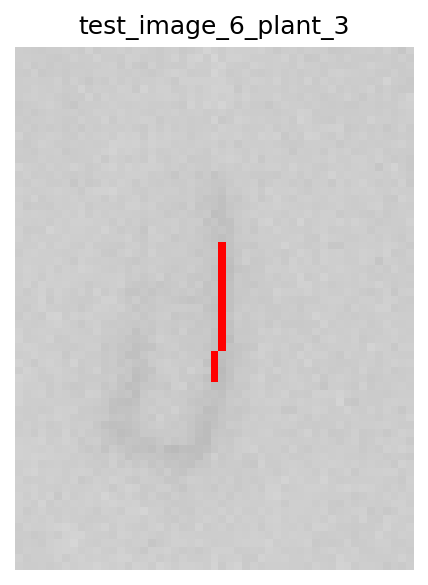

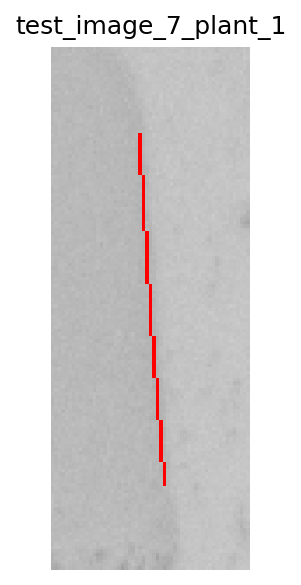

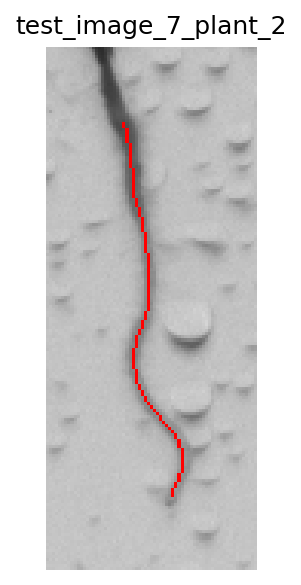

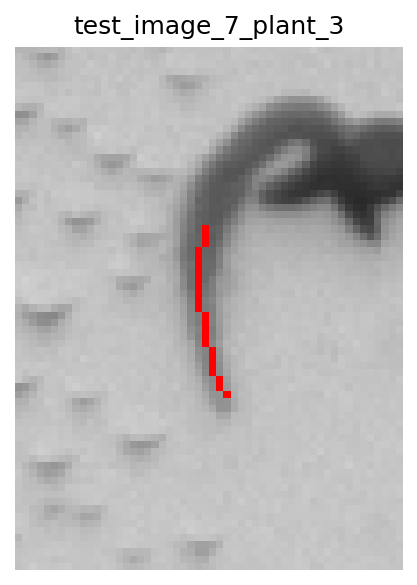

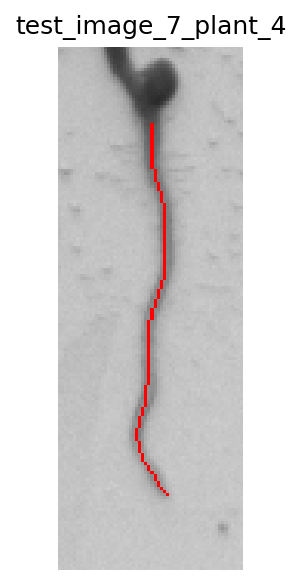

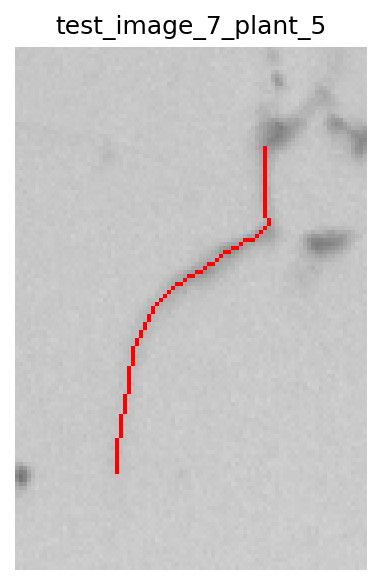

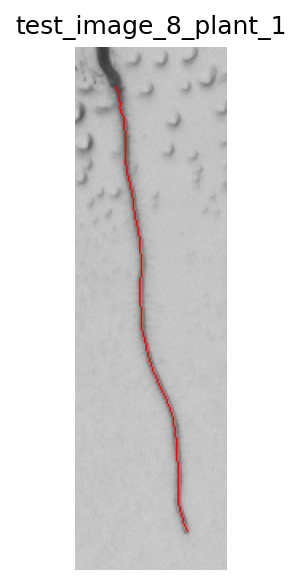

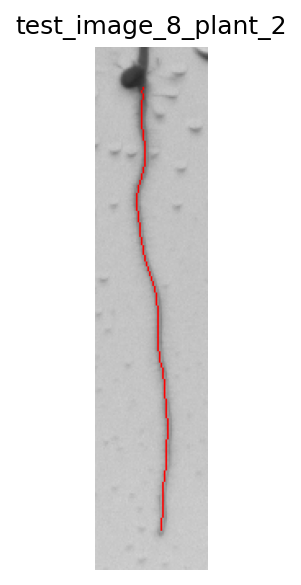

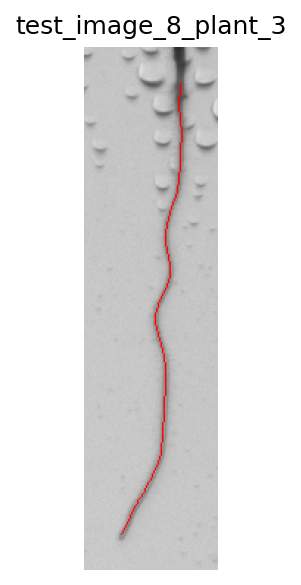

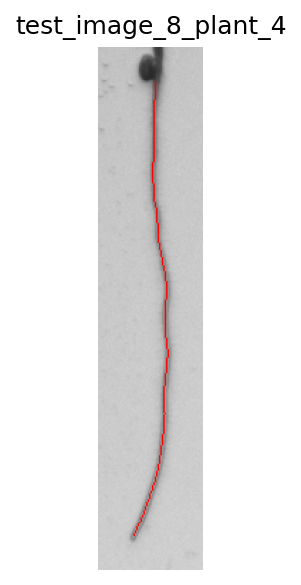

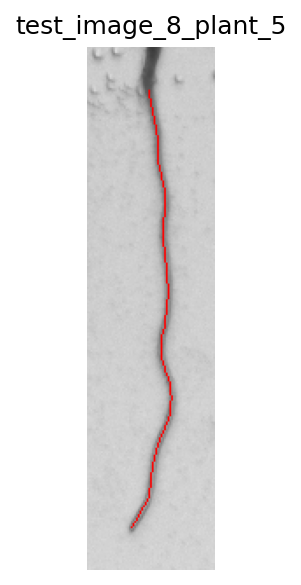

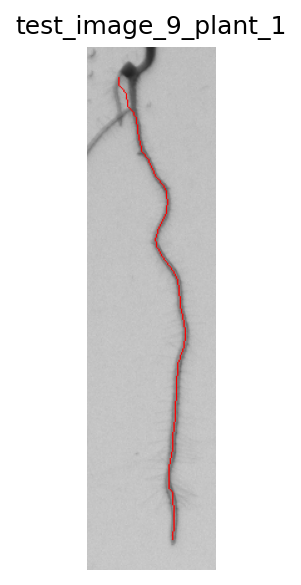

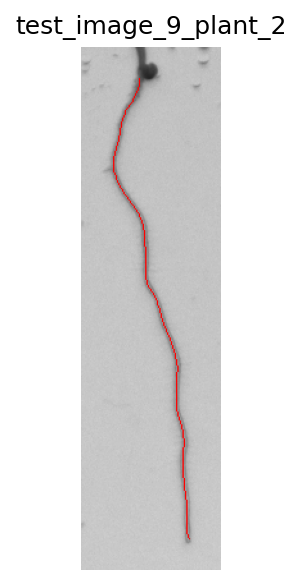

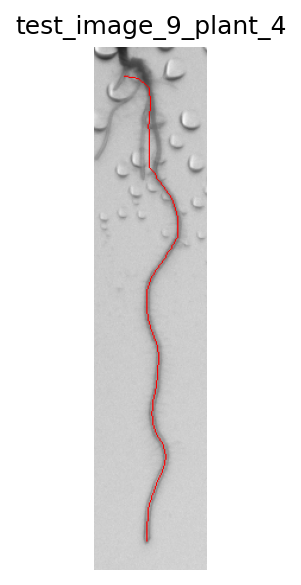

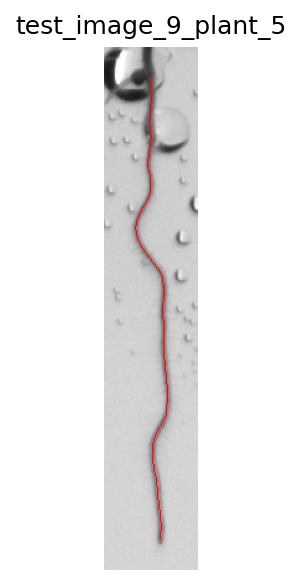

Saved primary root lengths to:
/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/Retake/Submissions/sub16.csv


In [18]:
# Imports
import os
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import tensorflow as tf
from tensorflow.keras.models import load_model
from skimage.morphology import skeletonize
import networkx as nx

%matplotlib inline

# Model and paths
patch_size = 256
model_path = r'/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/Retake/Model/1_celine_231265_unet_model_2_256px.h5'
test_folder = r'/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/Kaggle(Retake)'
csv_path   = r'/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/Retake/Submissions/sub16.csv'

# Custom F1 
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
        Positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
        return TP / (Positives + tf.keras.backend.epsilon())
    def precision_m(y_true, y_pred):
        TP = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
        Pred_Positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
        return TP / (Pred_Positives + tf.keras.backend.epsilon())
    p, r = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

# Load model
model = load_model(model_path, custom_objects={"f1": f1}, compile=False)

# Helper functions
def padder(image, patch_size):
    h, w = image.shape[:2]
    hp = ((h // patch_size) + 1) * patch_size - h
    wp = ((w // patch_size) + 1) * patch_size - w
    t, b = int(hp / 2), hp - int(hp / 2)
    l, r = int(wp / 2), wp - int(wp / 2)
    padded = cv2.copyMakeBorder(image, t, b, l, r, cv2.BORDER_CONSTANT, value=0)
    return padded, (t, b, l, r)

def unpadder(image, padding):
    t, b, l, r = padding
    return image[t:image.shape[0]-b, l:image.shape[1]-r]

def cropper(image):
    original_shape = image.shape
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(image, (11, 11), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image, {"original_shape": original_shape, "used_crop": False}
    largest = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)
    size = max(w, h)
    xc, yc = x + w // 2, y + h // 2
    xs, ys = max(0, xc - size // 2), max(0, yc - size // 2)
    cropped = image[ys:ys + size, xs:xs + size]
    return cropped, {"original_shape": original_shape, "used_crop": True,
                     "x_start": xs, "y_start": ys, "crop_size": size}

def uncropper(cropped_img, crop_info):
    canvas = np.zeros(crop_info["original_shape"][:2], dtype=cropped_img.dtype)
    if not crop_info.get("used_crop", False):
        return cropped_img
    xs, ys, size = crop_info["x_start"], crop_info["y_start"], crop_info["crop_size"]
    canvas[ys:ys + size, xs:xs + size] = cropped_img
    return canvas

# Predict raw masks
def predict_masks_raw(folder_path, model, patch_size=256):
    results = {}
    for filename in sorted(os.listdir(folder_path)):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
            continue
        print(f"\nProcessing {filename}")
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path, 0)
        petri, crop_info = cropper(image)
        petri_pad, pad_info = padder(petri, patch_size)
        patches = patchify(petri_pad, (patch_size, patch_size), step=128)
        ph, pw = patches.shape[:2]
        patches_rgb = np.repeat(patches, 3, axis=-1)
        model_in = patches_rgb.reshape(-1, patch_size, patch_size, 3) / 255.0
        preds = model.predict(model_in, verbose=0)
        preds = preds.squeeze().reshape(ph, pw, patch_size, patch_size)
        mask_pred = unpatchify(preds, petri_pad.shape)
        mask_unpad = unpadder(mask_pred, pad_info)
        mask_aligned = uncropper(mask_unpad, crop_info)

        results[filename] = {'mask': mask_aligned, 'crop_info': crop_info}

        f, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 4))
        ax[0].imshow(image, cmap='gray'); ax[0].set_title(f"{filename} — Original"); ax[0].axis('off')
        ax[1].imshow(mask_pred, cmap='gray'); ax[1].set_title("Raw Model Output"); ax[1].axis('off')
        ax[2].imshow(image, cmap='gray')
        ax[2].imshow(mask_aligned, cmap='Reds', alpha=(mask_aligned > 0.1) * 0.6)
        ax[2].set_title("Overlay: Prediction"); ax[2].axis('off')
        plt.tight_layout(); plt.show()

    return results

raw_predictions = predict_masks_raw(test_folder, model, patch_size)

# Threshold and morphological closing

threshold = 0.1
kernel_size = (3, 3)
kernel_shape = cv2.MORPH_ELLIPSE
dilate_iterations = 5
erode_iterations = 3

thresholded_masks = {name: (raw['mask'] > threshold).astype(np.uint8)
                     for name, raw in raw_predictions.items()}

closed_masks = {}
kernel = cv2.getStructuringElement(kernel_shape, kernel_size)

for name, binary in thresholded_masks.items():
    dilated = cv2.dilate(binary, kernel, iterations=dilate_iterations)
    closed = cv2.erode(dilated, kernel, iterations=erode_iterations)
    closed_masks[name] = closed

    fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
    axs[0].imshow(binary * 255, cmap='gray'); axs[0].set_title(f'{name} — Thresholded'); axs[0].axis('off')
    axs[1].imshow(closed * 255, cmap='gray'); axs[1].set_title(f'{name} — Closed & Cleaned'); axs[1].axis('off')
    plt.tight_layout(); plt.show()

# Crop and segment

top_crop_ratio = 0.15
num_plants = 5
min_area = 100
margin_edge = 50
aspect_ratio_threshold = 1.2
vertical_start_thresh_ratio = 0.25

dish_cropped_masks = {}
for name, closed in closed_masks.items():
    ci = raw_predictions[name]['crop_info']
    xs, size = ci['x_start'], ci['crop_size']
    xe = min(xs + size, closed.shape[1])
    horiz = closed[:, xs:xe]
    h = horiz.shape[0]
    t = int(h * top_crop_ratio)
    dish_cropped_masks[name] = horiz[t:, :]

segmented_root_masks = {}
for name, mask in dish_cropped_masks.items():
    h, w = mask.shape
    band_width = w / num_plants
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    plant_masks = [np.zeros_like(mask, dtype=np.uint8) for _ in range(num_plants)]

    for i in range(1, num_labels):
        x, y, cw, ch, area = stats[i]
        cx = centroids[i][0]
        if area < min_area: continue
        if x < margin_edge or x + cw > w - margin_edge: continue
        ar = ch / cw if cw > 0 else 0
        if ar < aspect_ratio_threshold: continue
        if y > int(h * vertical_start_thresh_ratio): continue
        band_idx = int(cx // band_width)
        band_idx = min(band_idx, num_plants - 1)
        comp = (labels == i).astype(np.uint8)
        if np.count_nonzero(plant_masks[band_idx]) < area:
            plant_masks[band_idx] = comp

    plant_masks = [(m * 255).astype(np.uint8) for m in plant_masks]
    segmented_root_masks[name] = plant_masks

# Measure root lengths (Dijkstra)

final_root_masks = {}
for name, plant_masks in segmented_root_masks.items():
    base = os.path.splitext(name)[0]
    for i, m in enumerate(plant_masks):
        final_root_masks[f"{base}_plant_{i+1}"] = m

primary_root_lengths = {}
for key, m in final_root_masks.items():
    binary = (m > 0).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)
    if num_labels <= 1:
        primary_root_lengths[key] = 0.0
        continue
    largest = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
    comp = (labels == largest).astype(np.uint8)
    skel = skeletonize(comp)
    if np.count_nonzero(skel) < 5:
        primary_root_lengths[key] = 0.0
        continue
    G = nx.Graph()
    coords = np.argwhere(skel)
    coord_set = set(map(tuple, coords))
    for y0, x0 in coords:
        for dy, dx in [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]:
            nb = (y0+dy, x0+dx)
            if nb in coord_set:
                G.add_edge((y0, x0), nb, weight=np.hypot(dy, dx))
    if G.number_of_nodes() == 0:
        primary_root_lengths[key] = 0.0
        continue
    top_node = min(G.nodes, key=lambda n: n[0])
    bottom_node = max(G.nodes, key=lambda n: n[0])
    try:
        path_len = nx.dijkstra_path_length(G, source=top_node, target=bottom_node, weight='weight')
    except nx.NetworkXNoPath:
        path_len = 0.0
    primary_root_lengths[key] = round(path_len, 2)

# Dijkstra overlay visualization

original_images_dir = test_folder
for key, m in final_root_masks.items():
    image_base = "_".join(key.split("_")[:-2]) + ".tif"
    img_path = os.path.join(original_images_dir, image_base)
    rgb = cv2.imread(img_path)
    if rgb is None: continue
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    ci = raw_predictions[image_base]["crop_info"]
    xs, size = ci["x_start"], ci["crop_size"]
    xe = min(xs + size, rgb.shape[1])
    rgb_crop = rgb[:, xs:xe]
    tc = int(rgb_crop.shape[0] * top_crop_ratio)
    rgb_final = rgb_crop[tc:, :]
    gray = cv2.cvtColor(rgb_final, cv2.COLOR_RGB2GRAY)
    gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    overlay = gray_rgb.copy()
    binary = (m > 0).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)
    if num_labels <= 1: continue
    largest = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
    comp = (labels == largest).astype(np.uint8)
    skel = skeletonize(comp)
    coords = np.argwhere(skel)
    coord_set = set(map(tuple, coords))
    G = nx.Graph()
    for y0, x0 in coords:
        for dy, dx in [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]:
            nb = (y0+dy, x0+dx)
            if nb in coord_set:
                G.add_edge((y0, x0), nb, weight=np.hypot(dy, dx))
    if G.number_of_nodes() == 0: continue
    try:
        top_node = min(G.nodes, key=lambda n: n[0])
        bottom_node = max(G.nodes, key=lambda n: n[0])
        path = nx.dijkstra_path(G, source=top_node, target=bottom_node, weight='weight')
    except nx.NetworkXNoPath:
        continue
    pts = []
    for (yy, xx) in path:
        if 0 <= yy < overlay.shape[0] and 0 <= xx < overlay.shape[1]:
            overlay[yy, xx] = [255, 0, 0]
            pts.append((yy, xx))
    if not pts: continue
    pts = np.array(pts)
    y_min, x_min = pts.min(axis=0)
    y_max, x_max = pts.max(axis=0)
    mrg = 25
    y_min = max(y_min - mrg, 0); y_max = min(y_max + mrg, overlay.shape[0])
    x_min = max(x_min - mrg, 0); x_max = min(x_max + mrg, overlay.shape[1])
    cropped_overlay = overlay[y_min:y_max, x_min:x_max]
    plt.figure(figsize=(4, 4), dpi=150)
    plt.imshow(cropped_overlay)
    plt.title(f"{key}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Export CSV
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Plant ID", "Length (px)"])
    for plant_id, length in primary_root_lengths.items():
        writer.writerow([plant_id, length])

print(f"Saved primary root lengths to:\n{csv_path}")
